In [4]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torchvision import datasets, models, transforms
import cv2
from PIL import Image
import numpy as np
import pandas as pd
import os

In [5]:
class MyDataset(Dataset):
    """My dataset."""

    def __init__(self, root_dir, class_path, transform=None):
        super(MyDataset, self).__init__()
        self.root_dir = root_dir
        self.class_path = class_path
        self.transform = transform
        
        # get image list
        all_list =  [os.path.splitext(f) for f in os.listdir(self.root_dir)] # jpg + txt
        assert [f for f,e in all_list if e=='.jpg'] == [f for f,e in all_list if e=='.txt'], "num_image != num_txt"
        self.data_list = [f for f,e in all_list if e=='.jpg']
        
        # get class list
        with open(class_path, 'r', encoding='utf-8') as f:
            self.classes = [c for c in f.read().split('\n')]
        self.class_to_idx = {self.classes[i]: i for i in range(len(self.classes))}

    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, idx):
        image_path = os.path.join(self.root_dir, self.data_list[idx]+'.jpg')
        ann_path = os.path.join(self.root_dir, self.data_list[idx]+'.txt')
        img = Image.open(image_path)
        with open(ann_path, 'r') as f:
            anno = [a.split(' ') for a in f.read().strip().split('\n')]
        anno = np.array(anno)
        labels = anno[:,0].astype(np.int) # - 10 ### 21개 클래스 쓸대는 -10 해줘야함
        bboxes_yolo = anno[:,1:].astype(np.float) # centerX, centerY, w, h [ratio] - yolo style
        bboxes = bboxes_yolo.copy() # x,y,w,h

        if self.transform:
            img = self.transform(img).unsqueeze(0)
            
        bboxes[:,0] = (bboxes_yolo[:,0] - bboxes_yolo[:,2]/2)*img.shape[3] # x
        bboxes[:,1] = (bboxes_yolo[:,1] - bboxes_yolo[:,3]/2)*img.shape[2] # y
        bboxes[:,2] = bboxes_yolo[:,2]*img.shape[3]
        bboxes[:,3] = bboxes_yolo[:,3]*img.shape[2]
        bboxes = bboxes.astype(np.int)

        return img, labels, bboxes, bboxes_yolo

---
# Classification

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, models, transforms
import cv2
from PIL import Image
import numpy as np
import pandas as pd
import os, shutil
from time import sleep
import subprocess
import matplotlib.pyplot as plt
import seaborn as sns
import torchvision
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from torch.distributions.multivariate_normal import MultivariateNormal
from tqdm import tqdm_notebook as tqdm

def my_cos(x,y):
    _x = F.normalize(x, p=2, dim=1)
    _y = F.normalize(y, p=2, dim=1)
    return _x.matmul(_y.transpose(0,1))

class Flatten(torch.nn.Module):
    """
    torch.nn.Sequential에서 사용가능한 flatten 모듈
    """
    def forward(self, x):
        batch_size = x.shape[0]
        return x.view(batch_size, -1)
    
class OracleModel(nn.Module):
    def __init__(self):
        """Load the pretrained ResNet-152 and replace top fc layer."""
        super(OracleModel, self).__init__()
#         ****torch pretrained net****
#         net = models.shufflenetv2.shufflenet_v2_x1_0(pretrained=True) # 1024
#         net = torch.hub.load('pytorch/vision', 'mobilenet_v2', pretrained=True)
#         net = models.mobilenet_v2(pretrained=True)
#         net = models.densenet201(pretrained=True)
        net = models.resnet50(pretrained=True)

        modules = list(net.children())[:-2]      # resnet conv_5
        self.backbone = torch.nn.Sequential(*modules) # 2048
        avg_pool = torch.nn.AdaptiveAvgPool2d(output_size=(1, 1))
        flatten = Flatten() 
        
        # fc layer
        self.fc = nn.Sequential(
            avg_pool,
            flatten
        ) # 2048
    
        self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        self.topk = 3
        self.threshold = 0.75
        self.feature_len = 2048

        self.sort_order_descending = False
        self.cos = nn.CosineSimilarity(dim=1, eps=1e-6)
        self.roi_upsample = nn.UpsamplingBilinear2d([224,224])
        self.roi_transform = transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                    ])
        
    def embed(self, images):
        r = self(images)
        return self.fc(r)

    def forward(self, images):
        """Extract feature vectors from input images."""
        return self.backbone(images)
    

    def makeAllReference_online(self, referenceImgDirPath):
        """
        임베딩 디비 생성... flask 서버용 
        utils.makeAllReferenceCSV 에서 csv 저장만 안함
        """
        reference_dataset = torchvision.datasets.ImageFolder(
            root=referenceImgDirPath,
            transform=transforms.Compose([
#                 transforms.Resize([224,224]),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ])
        )
        reference_loader = torch.utils.data.DataLoader(
            reference_dataset,
            batch_size=32,
            num_workers=0,
            shuffle=False
        )
        
        # get all data and input to model
        _temp = []
        for data, target in tqdm(reference_loader):
            outputs = self.embed(data.to(self.device)).data # .data 안하면 메모리 오버플로남...
            _temp.append(outputs)

        represented = torch.cat(_temp, dim=0)
        # raw data label 별 평균 구해두기
        self.df_ref_online = pd.DataFrame(represented.cpu().numpy())
        self.df_ref_online['label'] = [reference_dataset.classes[i] for i in reference_dataset.targets]
        self.reference_means_online = self.df_ref_online.groupby('label').mean()
        self.dir_list_online = reference_dataset.classes

        # 즉각 임베딩 디비 생성
        self.setReferenceDataset(self.dir_list_online, self.df_ref_online, self.reference_means_online)
        return self.dir_list_online, self.df_ref_online, self.reference_means_online

    def addNewData_online(self, im_arr, label):
        """
        @params im_arr: h X w X 3 (RGB)
        @params label: "praL"
        """
        data = self.roi_transform(im_arr).unsqueeze(0)
        outputs = self.embed(data.to(self.device)).data
        new_feature = list(outputs.squeeze().cpu().numpy())
        new_feature.append(label)
        new_feature[-1]
        # concat to prev df_ref_online
        self.df_ref_online.loc[self.df_ref_online.shape[0]] = new_feature
        # revise reference_means_online 
        self.reference_means_online = self.df_ref_online.groupby('label').mean()
        # 즉각 임베딩 디비 생성
        self.setReferenceDataset(self.dir_list_online, self.df_ref_online, self.reference_means_online)
        print('[Detector]: addNewData_online -', label)
        return

    def addNewLabel_online(self, dirPath, label):   
        """
        @params dirPath: "server/vu-visor/static/images_ext"
        @params label: "praL"
        """
        finalDirPath = os.path.join(dirPath, label)
        ims = [Image.open(os.path.join(finalDirPath,i)) for i in os.listdir(finalDirPath)] # n_img X h X w X c
        ims_tensor = torch.stack([self.roi_transform(im) for im in ims])
        outputs = self.embed(ims_tensor.to(self.device)).data
        new_features =outputs.cpu().numpy() # n_img X 2048

        new_df_ref_online = pd.DataFrame(new_features)
        new_df_ref_online['label'] = label
        # add new label
        if label not in self.dir_list_online: # 중복된 이름 없을 시 새로 등록
            self.dir_list_online.append(label)
            self.dir_list_online.sort() # 반드시 소팅해서 클래스 번호 재정렬 해줘야함
        # concat to prev df_ref_online
        _df_ref_online_non_overlap = self.df_ref_online[self.df_ref_online['label']!=label] # 중복된 이전 데이터 제거
        self.df_ref_online = pd.concat([_df_ref_online_non_overlap, new_df_ref_online], ignore_index=True)
        # revise reference_means_online 
        self.reference_means_online = self.df_ref_online.groupby('label').mean()
        # 즉각 임베딩 디비 생성
        self.setReferenceDataset(self.dir_list_online, self.df_ref_online, self.reference_means_online)
        print('[Detector]: addNewLabel_online -', label)
        return 
        
    # 임베딩 디비 생성
    def setReferenceDataset(self, sample_dir_list, df_ref_feature_sampled, reference_means_sampled):
        self.reference_classes = sample_dir_list
        self.reference_targets = list(df_ref_feature_sampled.iloc[:,-1])
        self.embedded_features_cpu = torch.tensor(df_ref_feature_sampled.iloc[:,:-1].as_matrix()).float().data # float64->float32(torch default), cpu
        self.embedded_features = self.embedded_features_cpu.to(self.device) # gpu
        self.embedded_means_numpy = reference_means_sampled.as_matrix()
        self.embedded_means = torch.tensor(self.embedded_means_numpy).float().data.to(self.device) # float64->float32(torch default), gpu

        self.c2i = {c:i for i,c in enumerate(self.reference_classes)}
        self.embedded_labels = torch.tensor([self.c2i[c] for c in self.reference_targets]).to(self.device)
        
        # make datafames for plot
        # ***필요없음 어차피 pca 해야함
        self.df_ = pd.DataFrame(np.array(self.embedded_features_cpu))
        self.df_['name'] = self.reference_targets
        self.centers_ = pd.DataFrame(self.embedded_means_numpy)
        self.centers_['name'] = self.reference_classes

    def fit_pca(self, n_components=4):
        # pca model fit
        self.n_components = n_components
        self.pca = PCA(n_components=self.n_components) # 2048 차원 다쓰면 나중에 샘플링에서 계산 오류남, sample 개수보다 많으면 촐레스키 분해 에러나는듯
        self.transformed = self.pca.fit_transform(self.embedded_features_cpu)

        # show PCA features 
        self.df = pd.DataFrame(self.transformed)
        self.df['name'] = self.reference_targets
        self.centers = pd.DataFrame(self.pca.transform(self.embedded_means_numpy))
        self.centers['name'] = self.reference_classes

    def inference_tensor3(self, inputs, metric='cos', knn=True):
        """
        roi 피처맵을(nxcx7x7) 인풋으로 받음
        @params metric: [l2, mahalanobis, prob]
        @params inputs: # N x C x H x W
        """            
        # inputs shape: Batch*C*H*W
        # input to backbone model
        self.inputs = inputs
        self.outputs = self.fc(self.inputs).data # n_roi X features 2048    

        # inference
        self.sort_order_descending = True         
        if knn: self.dists = my_cos(self.outputs, self.embedded_features)
        else: self.dists = my_cos(self.outputs, self.embedded_means)

        self.dists_sorted = self.dists.sort(dim=1, descending=self.sort_order_descending)
        if knn: self.predicts = self.embedded_labels[self.dists_sorted.indices][:,:self.topk]
        else: self.predicts = self.dists_sorted.indices[:,:self.topk]

        self.predicts_dist = self.dists_sorted.values[:,:self.topk]
        return self.predicts.data, self.predicts_dist.data    
    
    def inference_tensor_texture(self, inputs, metric='cos', knn=True, SUM=True):
        """
        현재 미니배치 1인 경우만 작동
        roi 피처맵을(nxcx7x7) 인풋으로 받음
        @params metric: [l2, mahalanobis, prob]
        @params inputs: # N x C x H x W
        """            
        # inputs shape: Batch*C*H*W
        # input to backbone model
        # 1 X 2048 X 7 X 7 --> 7*7 X 2048 --> 1 X 3
        # n X 2048 X 7 X 7 --> n*7*7 X 2048 --> n X 3
        self.outputs = inputs.data.transpose(1,2).transpose(2,3).reshape(-1,inputs.shape[1])
        # self.outputs = inputs.squeeze().transpose(0,1).transpose(1,2).reshape(-1,inputs.shape[1]).data 
        # 7*7 X features 2048   
        
        # inference
        self.sort_order_descending = True         
        if knn: self.dists = my_cos(self.outputs, self.embedded_features)
        else: self.dists = my_cos(self.outputs, self.embedded_means)

        self.dists_sorted = self.dists.sort(dim=1, descending=self.sort_order_descending)
        if knn: self.predicts = self.embedded_labels[self.dists_sorted.indices][:,:self.topk]
        else: self.predicts = self.dists_sorted.indices[:,:self.topk]

        self.predicts_dist = self.dists_sorted.values[:,:self.topk]

        if(SUM):
    #             ---- dist sum mode ----
            aa = pd.DataFrame(list(zip(self.predicts[:,0].cpu().numpy(), self.predicts_dist[:,0].cpu().numpy())), columns=['label','dist'])
            self.aa = aa
            # pp = aa.groupby('label').sum()
            # pp = pp.sort_values(by='dist', ascending=False)
            # pp = list(pp.index[:3])
            # if(len(pp)!=self.topk):
            #     pp = pp*self.topk
            #     pp = pp[:self.topk]
            
            # 배치별 번호 매기기
            self.aa['batch'] =  np.repeat(np.arange(inputs.shape[0]), inputs.shape[2]*inputs.shape[3])
            # 다중 그루핑
            zz = self.aa.groupby(['batch', 'label']).agg(['sum', 'mean', 'max'])
            # 2중 컬럼 인덱스 해제
            zz.columns = zz.columns.droplevel(0) 
            # sum 순으로 정렬
            zz = zz.reset_index().sort_values(by=['batch', 'sum'], ascending=False).set_index(['batch', 'label'])
            # 배치별 가장 큰 값만 리턴, dist는 선택 레이블의 평균값
            preds = zz.groupby('batch').head(1).sort_index(0).index.get_level_values(level=1).tolist()
            preds = np.repeat(preds, 3).reshape(-1,3)
            return torch.tensor(preds).data
        else:
    #             ---- voting mode ----
            c = Counter(torch.cat([*self.predicts]).cpu().numpy())
            self.c = c
            pp = list(zip(*(c.most_common()[:3])))[0]
            if(len(pp)!=self.topk):
                pp = pp*self.topk
                pp = pp[:self.topk]    
            return torch.tensor([pp]).data        

    def inference_tensor4(self, inputs):
        """
        roi 피처맵을(nxcx7x7) 인풋으로 받음
        """            
        # inputs shape: Batch*C*H*W
        # input to backbone model
        self.inputs = inputs
        self.outputs = self.fc(self.inputs).data # n_roi X features 2048    

        # inference
        self.dists = my_cos(self.outputs, self.embedded_means)
        self.predicts_dist = self.dists
        return self.predicts_dist.data    

    # 각 레이블 별 평균과의 L2 거리 계산 (PCA 적용안함)
    def calc_l2(self, label):
        mu = self.embedded_means[label]
        xx = self.outputs

        # 20*1280 X 1280*20 --diag--> 20
        # num_roi*dim X dim*num_roi --diag--> num_roi
        xx_sub_mu = xx.sub(mu)
        l2_dist = xx_sub_mu.matmul(xx_sub_mu.t()).sqrt().diag()
        return l2_dist.cpu()

    # 각 레이블 별 평균과의 cosine simility 계산 (PCA 적용안함)
    def calc_cos(self, label):
        mu = self.embedded_means[label]
        xx = self.outputs

        # 20*1280 X 1280*20 --diag--> 20
        # num_roi*dim X dim*num_roi --diag--> num_roi
        mu = mu.unsqueeze(0)
        cos_dist = self.cos(xx, mu)
        return cos_dist.cpu()        

    def inference_file(self, imgPath):              
        # imgPath = "./server/oracle_proj/predict.jpg"
        frame = cv2.imread(os.path.join(imgPath), cv2.IMREAD_COLOR)
        return self.inference_tensor(frame)

    def show_img(self, imgPath):
        frame = cv2.imread(os.path.join(imgPath), cv2.IMREAD_COLOR)
        # opencv frme input // H*W*C(BGR)
        # 0-255 3 channel
        inputs = torch.Tensor(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))/255 # 여기 Tensor 소문자로 바꾸면 안됨... 차이 알아보기
        plt.imshow(inputs)
        plt.show()
        
    def show_tensor(self, t):
        plt.imshow(t.numpy().transpose([1,2,0]))
        plt.show()
        
    def plot(self):
        self.fit_pca(n_components=4)
        _outputs = self.pca.transform(self.outputs.cpu())

        plt.figure(figsize=(18,9))
        plt.title("Vector space, pca_n: "+str(self.feature_len))
        ax = sns.scatterplot(x=0, y=1, hue='name', data=self.df, palette="Set1", legend="full")
        ax2 = sns.scatterplot(x=0, y=1, hue='name', data=self.centers, palette="Set1", s=150, legend=None, edgecolor='black')
        plt.scatter(_outputs[:,0], _outputs[:,1], marker='x', c='black')
        plt.show()

    # save plot image for web
    def save_plot(self, plotPath):
        self.fit_pca(n_components=4)
        _outputs = self.pca.transform(self.outputs.cpu())

        plt.figure(figsize=(9,9))
        plt.title("Vector space, pca_n: "+str(self.feature_len))
        ax = sns.scatterplot(x=0, y=1, hue='name', data=self.df, palette="Set1", legend="full", s=30)
        ax2 = sns.scatterplot(x=0, y=1, hue='name', data=self.centers, palette="Set1", s=150, legend=None, edgecolor='black')
        plt.scatter(_outputs[:,0], _outputs[:,1], marker='x', c='black', s=120)
        plt.savefig(plotPath)

In [7]:
### 모델 생성
model = OracleModel()
model.to(model.device)
model.eval()

OracleModel(
  (backbone): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d

In [8]:
"""
각종 util 함수들
"""
import PIL
from collections import Counter 


# -------------- 전체 임베딩 피처 디비 생성 --------------
def makeAllReferenceCSV(referenceImgDirPath, featuresPath, meanPath, n_sample=None):
    """
    전체 임베딩 피처 dataframe 생성 후 csv로 저장
    """
    reference_dataset = torchvision.datasets.ImageFolder(
        root=referenceImgDirPath,
        transform=transforms.Compose([
#             transforms.RandomRotation(90, expand=True),
            transforms.Resize([224,224]),
#             transforms.RandomHorizontalFlip(),
#             transforms.RandomRotation(45),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
    )
    reference_loader = torch.utils.data.DataLoader(
        reference_dataset,
        batch_size=32,
        num_workers=0,
        shuffle=False
    )

    # get all data and input to model
    _temp = []
    for data, target in tqdm(reference_loader):
        outputs = model.embed(data.to(model.device)).data # .data 안하면 메모리 오버플로남...
        _temp.append(outputs)       

    represented = torch.cat(_temp, dim=0)
    # raw data label 별 평균 구해두기
    df_ref = pd.DataFrame(represented.cpu().numpy())
    df_ref['label'] = [reference_dataset.classes[i] for i in reference_dataset.targets*1]
    
    # sampling
    if(n_sample is not None):
        df_ref_sampled = df_ref.groupby('label').apply(pd.DataFrame.sample, n=n_sample).reset_index(drop=True)
    else: df_ref_sampled = df_ref # no sampling
    reference_means = df_ref_sampled.groupby('label').mean()

    # 자료 저장
    df_ref_sampled.to_csv(featuresPath, encoding='utf8', index=False)
    reference_means.to_csv(meanPath, encoding='utf8', index=True)
    return

def set_sample_val_img(imgValPath, imgValTempPath, n_class_for_val, musthave_list=[]):
    """
    n개 클래스만 validation 샘플링 하는 함수
    @param imgValPath = '.\\img_real\\val'
    @param imgValTempPath = '.\\img_real\\_val_temp'
    @param n_class_for_val = 20
    @musthave_list = 반드시 포함할 리스트
    """
    all_dir_list = os.listdir(imgValPath)
    sample_dir_list = np.random.permutation(all_dir_list)[:n_class_for_val]
    for i in musthave_list:
        if i not in sample_dir_list: sample_dir_list = np.concatenate([sample_dir_list, [i]])

    # 추출될 이미지 저장 폴더 비우기... 비동기 버그 때문에 sleep넣음 
    if os.path.isdir(imgValTempPath): shutil.rmtree(imgValTempPath)
    sleep(0.1)
    os.makedirs(imgValTempPath)

    # copy sampled dir
    for class_name in tqdm(sample_dir_list):
        if not os.path.isdir(os.path.join(imgValTempPath, class_name)):
            os.mkdir(os.path.join(imgValTempPath, class_name))
        command = ['cmd', '\/c', 'copy',  os.path.join(imgValPath, class_name) , os.path.join(imgValTempPath, class_name)]    
        subprocess.check_output(command)
    sample_dir_list.sort() # 토치 데이터로더도 자동으로 이름순 소팅하므로 꼭 해야함
    return list(sample_dir_list)

def get_sample_reference(featuresPath, meanPath, showData=False):
    """
    n개 클래스 임베딩 & 레이블 & means 추출 
    """
    # load saved embedding features & means
    df_ref = pd.read_csv(featuresPath, encoding='utf8')
    reference_means = pd.read_csv(meanPath, encoding='utf8', index_col='label')
    
    if showData:
        display(df_ref)
        display(reference_means)

    df_ref_featere_sampled = None
    for c in sample_dir_list:
        _df = df_ref[df_ref['label'] == c]
        if df_ref_featere_sampled is None: df_ref_featere_sampled = _df
        else: df_ref_featere_sampled = df_ref_featere_sampled.append(_df)

    df_ref_featere_sampled = df_ref_featere_sampled.reset_index(drop=True)
    reference_means_sampled = reference_means.loc[sample_dir_list]
    return df_ref_featere_sampled, reference_means_sampled

def calcWindowSlidePreds(target_all, preds_all, n_window=7, mode="first"):
    """
    target_all = 정답 리스트
    preds_all = 예측값 리스트 
    mode = 'all' # first, all
    n_window = 3 
    @return new_preds_all = []
    """
    
    # preds, gt 모아서 데이터프레임화
    df = pd.DataFrame(preds_all.numpy())
    df['gt']= target_all.numpy()

    # 클래스별 인덱스 시작점 계산. 데이터로더 셔플하면 안됨
    df_agg = df.groupby('gt').count()
    df_agg['end_idx'] = df_agg[0].cumsum()

    # 윈도 내 데이터 voting
    startidx = 0
    new_preds_all = []
    for i in df_agg.index:
        for idx in range(startidx, df_agg['end_idx'][i]):
            bookmarkidx = idx-n_window+1 if idx-n_window>=0 else 0
            if idx-n_window<startidx:
                bookmarkidx = startidx

            if mode=='all': # 1~3위 까지 전체 사용 모드, [::-1] 은 가장 최근 값을 맨 앞으로 보내려고
                res = np.concatenate(preds_all[bookmarkidx:idx+1].numpy()[::-1])
            elif mode=='first': # 1위만 사용모드       
                res = preds_all[bookmarkidx:idx+1, 0].numpy()[::-1]
            res_cnt = Counter(res) # counter는 먼저나온 값이 먼저 등록됨, 즉 카운터가 동률이면 최신값이 가장 먼저 나옴
#             print(idx-n_window, idx, bookmarkidx, idx+1, res, res_cnt.most_common()[:2], '[Pred]:', res_cnt.most_common()[0][0])
            new_preds_all.append(res_cnt.most_common()[0][0])
#         print('-------------------------')
        startidx = df_agg['end_idx'][i]
    return new_preds_all

---
## Make custom data feature matrix

In [21]:
"""
전체 피처 데이터 재생성
"""
referenceImgDirPath = '.\\references\\images_trimed_21-10shot' # 21 classes

featuresPath = 'cosmetic_features_cos.csv'
meanPath = 'cosmetic_means_cos.csv'
makeAllReferenceCSV(referenceImgDirPath, featuresPath, meanPath, n_sample=None)

A Jupyter Widget

In [9]:
"""
전체 피처 데이터 재생성
"""
referenceImgDirPath = '.\\references\\images_trimed_10-10shot' # 10 classes
featuresPath = 'cosmetic_features_cos.csv'
meanPath = 'cosmetic_means_cos.csv'
makeAllReferenceCSV(referenceImgDirPath, featuresPath, meanPath, n_sample=None)

A Jupyter Widget

In [10]:
# -------------- n개 클래스만 validation 샘플링 세팅 및 폴더정리 ----------------
reference_dataset = torchvision.datasets.ImageFolder(
    root=referenceImgDirPath,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
)
sample_dir_list = reference_dataset.classes

# -------------- 레퍼런스 데이터에서 n개 클래스 임베딩 & 레이블 & means 추출 -----------------
featuresPath = 'cosmetic_features_cos.csv'
meanPath = 'cosmetic_means_cos.csv'

df_ref_featere_sampled, reference_means_sampled = get_sample_reference(featuresPath, meanPath, showData=True)

# ---------------------------- 레퍼런스셋 로드 및 임베딩 세팅 ---------------------------------
model.setReferenceDataset(sample_dir_list, df_ref_featere_sampled, reference_means_sampled)

,0,1,2,3,4,5,6,7,8,9,...,2039,2040,2041,2042,2043,2044,2045,2046,2047,label
0,0.301848,0.447783,0.737731,0.204914,0.392145,0.920094,0.310044,0.199206,0.146459,0.050588,...,0.263989,0.420457,0.580487,0.095794,0.057374,0.594879,0.874467,0.512844,0.985858,AHC-AGELESS REAL EYE CREAM FOR FACE
1,0.244127,0.184330,0.819666,0.345009,1.507725,0.733602,0.078871,0.051953,0.121963,0.028002,...,0.387964,0.366459,0.357513,0.493359,0.087185,0.276187,0.137212,0.291368,0.482486,AHC-AGELESS REAL EYE CREAM FOR FACE
2,0.245856,1.309269,0.354200,0.468166,0.620318,1.559992,0.909708,0.196827,0.343104,0.067652,...,0.208137,0.476136,0.327448,0.628182,0.062936,0.471073,0.147845,0.257986,0.483393,AHC-AGELESS REAL EYE CREAM FOR FACE
3,1.243421,0.669135,0.638158,0.439622,0.792984,1.350624,1.216563,0.498700,0.295312,0.146933,...,0.204064,0.593327,1.030024,0.879201,0.177972,0.252241,0.202362,0.224722,0.167485,AHC-AGELESS REAL EYE CREAM FOR FACE
4,1.479023,0.791252,1.649451,0.409297,0.671953,1.423973,0.251561,1.090502,0.211648,0.191059,...,0.049868,0.507990,0.712117,1.021986,0.128523,0.346383,0.439632,0.222509,0.189037,AHC-AGELESS REAL EYE CREAM FOR FACE
5,0.991540,1.020746,1.798223,0.401704,0.856955,1.127063,1.046117,0.556211,0.517635,0.320038,...,0.315602,0.634980,0.327900,0.244039,0.220743,0.336442,0.044026,0.385989,0.324572,AHC-AGELESS REAL EYE CREAM FOR FACE
6,1.042674,0.297451,1.266112,0.751014,0.423628,0.873794,0.591668,0.533189,0.329367,0.106006,...,0.310476,0.325687,0.386298,1.131685,0.124538,0.404797,0.180080,0.265675,0.229746,AHC-AGELESS REAL EYE CREAM FOR FACE
7,0.058758,0.682577,0.672170,0.092239,0.618472,0.707633,0.562048,0.268817,0.697828,0.413518,...,0.378564,0.350061,0.467298,0.101682,0.106223,0.146766,0.163086,0.368374,0.412753,AHC-AGELESS REAL EYE CREAM FOR FACE
8,0.857099,0.473287,0.721504,0.420178,1.058069,0.638609,0.542285,0.331540,0.527936,0.157912,...,0.165251,0.496962,0.186689,0.050651,0.021503,0.331836,0.519920,0.617605,0.374492,AHC-AGELESS REAL EYE CREAM FOR FACE
9,0.497020,0.342160,0.346559,1.111026,0.625200,0.528618,0.785394,0.528513,0.673358,0.482970,...,0.082152,0.751742,0.909081,0.075040,0.089164,0.501863,0.170309,0.409508,0.777837,AHC-AGELESS REAL EYE CREAM FOR FACE


,0,1,2,3,4,5,6,7,8,9,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
label,,,,,,,,,,,,,,,,,,,,,
AHC-AGELESS REAL EYE CREAM FOR FACE,0.696137,0.621799,0.900377,0.464317,0.756745,0.986400,0.629426,0.425546,0.386461,0.196468,...,0.376075,0.236607,0.492380,0.528486,0.472162,0.107616,0.366247,0.287894,0.355658,0.442766
AHC-Aura Secret Toneup Cream,1.286258,0.795473,1.092174,0.336691,0.694374,1.618653,0.198129,1.018523,0.426907,0.377551,...,0.453377,0.484520,0.364986,0.426330,0.414895,0.112674,0.310452,0.254941,0.167797,0.690387
AHC-ONLY FOR MAN LOTION,0.761013,0.492799,0.195262,0.441887,0.453298,0.756997,0.316676,0.338431,0.291991,0.189543,...,0.423611,0.167479,0.247719,0.319433,0.765013,0.126315,0.349074,0.113302,0.351403,0.980073
APIEU-데카소사이드 시카 겔 데이크림,1.095429,0.390945,0.805390,0.366859,0.623491,0.355817,1.139962,0.430234,0.195048,0.171364,...,0.457553,0.243265,0.564425,0.643652,0.207364,0.128459,0.604323,0.311341,0.564722,1.548930
APIEU-스타트업 포어 프라이머,0.591370,0.842059,1.143563,0.266920,0.862271,0.711895,1.302300,0.716502,0.599604,0.443720,...,0.192611,0.149638,0.391112,0.660270,0.649037,0.077859,0.337999,0.432314,0.299763,0.937574
BANILACO-프라임 프라이머 클래식,0.910288,1.094280,1.161939,0.249828,0.762273,1.109972,0.646333,0.309972,0.389212,0.171986,...,0.260749,0.299201,0.402422,0.387161,0.859594,0.029101,0.265983,0.375829,0.492117,1.164465
BELIF-The true cream AQUA BOMB,0.650618,0.809720,1.027345,0.285462,0.633931,0.541393,1.206680,0.545582,0.414820,0.296532,...,0.424160,0.174828,0.483429,0.721471,0.840979,0.118789,0.773156,0.296385,0.624027,1.233082
CLIO-스파클링 라인 프리즘 에어 아이섀도우,0.660018,0.679126,0.229218,0.098108,1.140669,0.125305,0.813773,0.690848,0.718301,0.233223,...,0.737613,0.239247,0.316308,0.434369,0.461082,0.080391,0.214959,0.088098,0.188387,0.374652
FERRAGAMO-INCANTO CHARMS,1.543649,0.520750,1.189078,0.298157,0.335243,0.330352,0.128212,0.342107,0.510459,0.222883,...,1.104215,0.296567,0.257822,0.816763,0.372637,0.101514,0.296845,0.183662,0.777283,0.361952


---
## PASCAL VOC SETTING
> PASCAL VOC 데이터 이용하는 경우에만 해당

In [22]:
# *********************pascal voc***********************
voc_classes = ['aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat',
                'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person',
                'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor']
voc_c2i = {c:i for i,c in enumerate(voc_classes)}

### 데이터셋 로드
voc_dataset = torchvision.datasets.VOCDetection(root='./data', year='2012', image_set='train', download=False, 
        transform=transforms.Compose([
#         transforms.Resize([224,224]),
#         transforms.RandomHorizontalFlip(),
#         transforms.RandomRotation(45),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]))
voc_loader = torch.utils.data.DataLoader(voc_dataset, batch_size=1,
                                          shuffle=True, num_workers=4)
# *********************pascal voc***********************

In [23]:
# """
# voc 레퍼런스 csv 만들기
# 최초 1회만 시행
# """
# def get_rois(images, featuremaps, bboxes, texture_mode=False, n_slice=3):
#     """
#     roi-align from feature map
#     @params images - 원본 이미지 (사이즈 계산용)
#     @params featuremaps - CNN Backbone 거쳐 나온 것
#     @params bboxes - 원본 이미지에서의 bboxes (x,y,w,h)
#     @return 피처맵에서 스케일된 bbox부분 7x7로 roi-align된 피처맵
#     """
#     # calc bbox ratio
#     ratio_y = featuremaps.shape[2]/images.shape[2]
#     ratio_x = featuremaps.shape[3]/images.shape[3]
#     bboxes_scaled = bboxes.clone()#.detach()

#     bboxes_scaled[:,0] = bboxes_scaled[:,0]*ratio_x # for x
#     bboxes_scaled[:,1] = bboxes_scaled[:,1]*ratio_y # for y
#     bboxes_scaled[:,2] = bboxes_scaled[:,2]*ratio_x # for w
#     bboxes_scaled[:,3] = bboxes_scaled[:,3]*ratio_y # for h

#     # x,y,w,h -> x1, y1, x2, y2 그래디언트 학습되는 변수가 아니므로 inplace 계산 들어가도 괜찮다
#     bboxes_scaled[:, 2] = bboxes_scaled[:, 0] + bboxes_scaled[:, 2]
#     bboxes_scaled[:, 3] = bboxes_scaled[:, 1] + bboxes_scaled[:, 3]
    
#     crops = torchvision.ops.roi_align(featuremaps, [bboxes_scaled], [224,224])
#     return crops

# _temp = []
# targets = []; diffs=[]; truncateds=[]; areas = []
# for data, target in tqdm(voc_loader):
#     infos =  target['annotation']['object']
#     if(type(infos)==list): # bbox 여러개
#         targets+=list(map(lambda x: x['name'][0], infos))
#         diffs +=list(map(lambda x: x['difficult'][0], infos))
#         truncateds +=list(map(lambda x: x['truncated'][0], infos))
#     else: # bbox 한 개 - 이 경우는 infos가 그냥 dict로 나옴... 더럽네
#         targets += infos['name']
#         diffs += infos['difficult']
#         truncateds += infos['truncated']                
#         infos = [infos]
        
#     boxes = []
#     for info in infos:
#         x1 = int(info['bndbox']['xmin'][0])
#         x2 = int(info['bndbox']['xmax'][0])
#         y1 = int(info['bndbox']['ymin'][0])
#         y2 = int(info['bndbox']['ymax'][0])
#         box = [x1, y1, x2-x1, y2-y1] # x,y,w,h
#         boxes.append(box)
#         areas.append((x2-x1)*(y2-y1))
        
#     boxes = np.array(boxes)
#     featuremaps = model(data.to(model.device))

#     _boxes_cuda = torch.from_numpy(boxes).float().cuda()
#     rois = get_rois(data, featuremaps, _boxes_cuda).data
#     rois = model.fc(rois).cpu()
#     _temp.append(rois)
    
# represented = torch.cat(_temp, dim=0)
# # raw data label 별 평균 구해두기
# df_ref = pd.DataFrame(represented.numpy())
# df_ref['label'] = targets
# # df_ref['area'] = areas
# # df_ref['difficult'] = diffs
# # df_ref['truncated'] = truncateds
# df_ref_adj = df_ref

# # # 잘린 이미지와 어려운 이미지 제거
# # mask = [x and y and z for x,y,z in 
# #         zip(df_ref['difficult']!='1', df_ref['truncated']!='1', df_ref['area']>15000)]
# # df_ref_adj = df_ref[mask].drop(labels=['difficult', 'truncated', 'area'], axis=1)

# # # **************5-shot sampling****************
# # df_ref_adj = df_ref_adj.sample(frac=1).groupby('label').head(5)

# reference_means = df_ref_adj.groupby('label').mean()

# # 자료 저장
# df_ref_adj.to_csv('reference_features_voc.csv', encoding='utf8', index=False)
# reference_means.to_csv('reference_means_voc.csv', encoding='utf8', index=True)

In [24]:
### 만들어둔 피처벡처 로드

featuresPath = 'reference_features_voc.csv'
meanPath = 'reference_means_voc.csv'

sample_dir_list = voc_classes
# -------------- 레퍼런스 데이터에서 n개 클래스 임베딩 & 레이블 & means 추출 -----------------
df_ref_featere_sampled, reference_means_sampled = get_sample_reference(featuresPath, meanPath, showData=False)

# ---------------------------- 레퍼런스 셋 로드 및 임베딩 세팅 ---------------------------------
model.setReferenceDataset(sample_dir_list, df_ref_featere_sampled, reference_means_sampled)

In [25]:
def voc_cvt(data, target):
    """
    voc dataloader를 받아와서 bbox 배치로 내보내줌
    voc dataloader의 batch size는 반드시 1이어야 오류 안남
    @return bboxes - x,y,w,h
    """
    global voc_c2i
    _temp_targets = []
    _temp_bboxes = []
    infos =  target['annotation']['object']
    filename =  target['annotation']['filename'][0]
    if(type(infos)==list): # bbox 여러개
        _temp_targets+=list(map(lambda x: x['name'][0], infos))
    else: # bbox 한 개 - 이 경우는 infos가 그냥 dict로 나옴... 더럽네
        _temp_targets += infos['name']
        infos = [infos]
        
    for info in infos:
        x1 = int(info['bndbox']['xmin'][0])
        x2 = int(info['bndbox']['xmax'][0])
        y1 = int(info['bndbox']['ymin'][0])
        y2 = int(info['bndbox']['ymax'][0])
        _temp_bboxes.append([x1,y1,x2-x1,y2-y1]) # x,y,w,h

#     print(_temp_targets)
    targets = np.array([voc_c2i[c] for c in _temp_targets])
    bboxes = np.array(_temp_bboxes)
    return targets, bboxes, filename

In [17]:
# ---------------------------- val set 로드 ---------------------------------
voc_val_dataset = torchvision.datasets.VOCDetection(root='./data', year='2012', image_set='val', download=False, 
        transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]))
voc_val_loader = torch.utils.data.DataLoader(voc_val_dataset, batch_size=1,
                                          shuffle=True, num_workers=4)


# ---------------------------- val set 정확도 측정 ---------------------------------
print('**********calculating***********')

target_all = []
preds_all = []
for im_tensor, target in tqdm(voc_val_loader):
#     data, target, _d, _f = voc_cvt(data, target) # 반드시!!!!!!!!!!!!!!
#     preds, preds_dist = model.inference_tensor2(data.to(model.device), 'cos')
#     target_all.append(target)
#     preds_all.append(preds.data)
    
    featuremaps = model(im_tensor.to(model.device))
    targets_gt, boxes_gt, filename_gt = voc_cvt(im_tensor, target) # 정답 데이터, 레이블, bbox
    target_all = np.concatenate([target_all,  targets_gt])
    
    _boxes_cuda = torch.from_numpy(boxes_gt).float().cuda()
    rois = get_rois(im_tensor, featuremaps, _boxes_cuda)
    preds, preds_dist= model.inference_tensor3(rois, 'cos', knn=False)
    preds_all.append(preds.data)
    

target_all=torch.tensor(target_all).data.int()
preds_all=torch.cat(preds_all, dim=0).data.int().cpu()
top1_acc = target_all.int().eq(preds_all[:,0]).float().mean()
top3_acc = np.mean([t in p for t,p in zip(target_all, preds_all)])

# groupby 통계량 보기
_res = []
for t,p in zip(target_all.numpy(), preds_all.numpy()):
    _res.append([voc_classes[t],t,p,t==p[0], t in p])
_df_res = pd.DataFrame(_res, columns=['label', 'target', 'pred', 'top1', 'top3'])
res_agg_df = _df_res.groupby('label').mean()
res_agg_df['count'] = list(_df_res.groupby('target').count()['label'])

display(res_agg_df)
print("[top-1 acc]:", top1_acc, " [top-3 acc]:", top3_acc, " [all count]:",len(target_all))

**********calculating***********


A Jupyter Widget

,target,top1,top3,count
label,,,,
aeroplane,0,0.909091,0.964876,484
bicycle,1,0.834211,0.926316,380
bird,2,0.903021,0.949126,629
boat,3,0.908350,0.955193,491
bottle,4,0.792633,0.901774,733
bus,5,0.906250,0.981250,320
car,6,0.770673,0.913043,1173
cat,7,0.914239,0.980583,618
chair,8,0.561077,0.913043,1449


[top-1 acc]: tensor(0.7217)  [top-3 acc]: 0.9362766833470577  [all count]: 15787


In [27]:

def plotHeatMap(preds):
    fig = plt.figure(figsize=(20,15))
    for j in range(4):
        for i in range(5):
            n_fig = i+j*5+1
            if(n_fig==20):
                break
            a=fig.add_subplot(4,5,n_fig)
            imgplot = plt.imshow(preds_dist.cpu()[n_fig-1], cmap='jet')
            imgplot.set_clim(0,1)
            a.set_title(str(n_fig-1)+'//'+voc_classes[n_fig-1].split(' ')[0])
    plt.colorbar(ticks=[0.1,0.3,0.5,0.7,0.9], orientation ='horizontal')
    plt.show()
    return

def cvt2yolobox(bboxes, size):
    """
    size - original [w,h]
    np.array
    x,y,w,h to yolo(cx,cy,w,h)
    """
    bboxes_yolo = bboxes.copy().astype(np.float) # x,y,w,h

    bboxes_yolo[:,0] = (bboxes[:,0] + bboxes[:,2]/2)/size[1] # x
    bboxes_yolo[:,1] = (bboxes[:,1] + bboxes[:,3]/2)/size[0] # y
    bboxes_yolo[:,2] = bboxes[:,2]/size[1]
    bboxes_yolo[:,3] = bboxes[:,3]/size[0]
    return bboxes_yolo

In [104]:
# import time
# # ---------------------------- val set 로드 ---------------------------------
# voc_val_dataset = torchvision.datasets.VOCDetection(root='./data', year='2012', image_set='trainval', download=False, 
#         transform=transforms.Compose([
#         transforms.ToTensor(),
#     ]))

# voc_val_loader = torch.utils.data.DataLoader(voc_val_dataset, batch_size=1,
#                                           shuffle=True, num_workers=4)

# voc_transform = transforms.Compose([
#         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
#     ])
# # assert val_dataset.classes==sample_dir_list, "샘플링 클래스와 데이터로더 클래스가 다름"
# # ---------------------------- val set 정확도 측정 ---------------------------------

fps=0
# model.threshold = 0.9*0.08 #0.85 #0.4
model.threshold = 0.88
SHOW_IMAGE = False # 이미지 볼지 말지
USE_KNN = False
dfs = {c:pd.DataFrame(columns=['image', 'confidience', 'TP', 'IOU']) for c in voc_classes} # average precision 저장
target_all_mAP = []

target_all = [] #ground truth bboxs
heat_all = []
box_yolo_all = []
sobel_all = []

vocList = os.listdir('voc-plot')
# allowedList = [0,1,2,6,7,9,11,12,13,16,18]
allowedList = list(range(20))
print('[num_class]:', len(sample_dir_list), sample_dir_list)
for data, target in tqdm(voc_val_loader):
    startTime = time.time()

    frame = data.clone().detach().mul(255).squeeze().numpy().astype(np.uint8).transpose([1,2,0])
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB) # opencv image need to convert BGR -> RGB

    im_tensor = voc_transform(data.squeeze()).to(model.device).data.unsqueeze(0)
    featuremaps = model(im_tensor)
    targets_gt, boxes_gt, filename_gt = voc_cvt(im_tensor, target) # 정답 데이터, 레이블, bbox
    if(len(targets_gt)!=1): continue # 물체 하나만 있는거
    if(targets_gt.item() not in allowedList): continue
    boxes_gt_yolo = cvt2yolobox(boxes_gt, frame.shape[:2])
    area = boxes_gt_yolo[0][2]*boxes_gt_yolo[0][3]
    if(area<0.01 or area>0.64): continue # 0.1^2 <= area <= 0.8^2
    target_all_mAP = np.concatenate([target_all_mAP,  targets_gt])
        
    if SHOW_IMAGE:
        # render ground truth roi prediction
        cv2.putText(frame, str(float(preds_dist.mean()))[:5], (20,30), cv2.FONT_HERSHEY_SIMPLEX, fontScale=1, color=(0,200,225), thickness=2) # roi평균 유사도
        _boxes_gt_cuda = torch.from_numpy(boxes_gt).float().cuda()
        rois_gt = get_rois(im_tensor, featuremaps, _boxes_gt_cuda)
        preds_gt, pred_dists_gt = model.inference_tensor3(rois_gt, 'cos', knn=USE_KNN)    
        for pred, dist, b in zip(preds_gt[:,0], pred_dists_gt[:,0], boxes_gt):
            pred_label = voc_classes[pred]
            res_text = pred_label+"("+str(float(dist))[:5]+")"
            x, y, w, h = b
            cv2.putText(frame, res_text, (x+3, y+12), cv2.FONT_HERSHEY_SIMPLEX, fontScale=.5, color=(255,0,255), thickness=1)
            cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 1, cv2.LINE_AA)  
        
    _data = nn.UpsamplingNearest2d([224,224])(data)
    data_sobel = sobel(_data.cuda())
                
#     preds_dist = textureDetect(featuremaps, filter_size=(3,3), stride=(0.33, 0.33))
    preds_dist = textureDetectMultiChannel(featuremaps, stride=(0.25, 0.25))
    heat_all.append(preds_dist.cpu()) # heatmap
    box_yolo_all.append(boxes_gt_yolo)
    target_all.append(targets_gt)
    sobel_all.append(data_sobel[0].cpu().data)

#     """box maker"""
#     %time preds_dist = textureDetect(featuremaps, filter_size=(5,5), upsample=True, upsample_scale=3)
#     plotHeatMap(preds_dist)
# #     print(im_tensor.shape, featuremaps.shape)
#     ans = preds_dist.argmax(dim=0).cpu()
#     imgplot = plt.imshow(ans, cmap='jet')
#     imgplot.set_clim(0,20)
#     plt.colorbar(ticks=[0,2,4,6,8,10,12,14,16,18,20], orientation ='vertical')
#     plt.show()
#     print('--------------------------------------')
#     """"""""""""""""""
    if targets_gt[0] in [14,17,8,10]: saveWrongImg(startTime)
    # only render UI
    if SHOW_IMAGE:
        frame = cv2.resize(frame, (int(frame.shape[1]*1.5), int(frame.shape[0]*1.5)), interpolation=cv2.INTER_CUBIC)
        cv2.imshow('frame',frame)
        k = cv2.waitKey(0) & 0xff 
        if k == 27: # esc
            break

    endTime = time.time()
    fps = int(1/(endTime - startTime))
        
cv2.destroyAllWindows()

[num_class]: 20 ['aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor']


A Jupyter Widget

<featuremaps-shape> torch.Size([1, 2048, 16, 12])
<roi-align> torch.Size([16470, 2048])
<class, roi-shape> torch.Size([16470, 20]) 6 61 45 -->  (224,224)
[n_box]: 16470
<featuremaps-shape> torch.Size([1, 2048, 8, 16])
<roi-align> torch.Size([10614, 2048])
<class, roi-shape> torch.Size([10614, 20]) 6 29 61 -->  (224,224)
[n_box]: 10614
<featuremaps-shape> torch.Size([1, 2048, 11, 16])
<roi-align> torch.Size([15006, 2048])
<class, roi-shape> torch.Size([15006, 20]) 6 41 61 -->  (224,224)
[n_box]: 15006
<featuremaps-shape> torch.Size([1, 2048, 12, 16])
<roi-align> torch.Size([16470, 2048])
<class, roi-shape> torch.Size([16470, 20]) 6 45 61 -->  (224,224)
[n_box]: 16470
<featuremaps-shape> torch.Size([1, 2048, 11, 16])
<roi-align> torch.Size([15006, 2048])
<class, roi-shape> torch.Size([15006, 20]) 6 41 61 -->  (224,224)
[n_box]: 15006
<featuremaps-shape> torch.Size([1, 2048, 16, 12])
<roi-align> torch.Size([16470, 2048])
<class, roi-shape> torch.Size([16470, 20]) 6 61 45 -->  (224,224)
[n

<class, roi-shape> torch.Size([15006, 20]) 6 41 61 -->  (224,224)
[n_box]: 15006
<featuremaps-shape> torch.Size([1, 2048, 11, 16])
<roi-align> torch.Size([15006, 2048])
<class, roi-shape> torch.Size([15006, 20]) 6 41 61 -->  (224,224)
[n_box]: 15006
<featuremaps-shape> torch.Size([1, 2048, 11, 16])
<roi-align> torch.Size([15006, 2048])
<class, roi-shape> torch.Size([15006, 20]) 6 41 61 -->  (224,224)
[n_box]: 15006
<featuremaps-shape> torch.Size([1, 2048, 12, 16])
<roi-align> torch.Size([16470, 2048])
<class, roi-shape> torch.Size([16470, 20]) 6 45 61 -->  (224,224)
[n_box]: 16470
<featuremaps-shape> torch.Size([1, 2048, 12, 16])
<roi-align> torch.Size([16470, 2048])
<class, roi-shape> torch.Size([16470, 20]) 6 45 61 -->  (224,224)
[n_box]: 16470
<featuremaps-shape> torch.Size([1, 2048, 11, 16])
<roi-align> torch.Size([15006, 2048])
<class, roi-shape> torch.Size([15006, 20]) 6 41 61 -->  (224,224)
[n_box]: 15006
<featuremaps-shape> torch.Size([1, 2048, 16, 12])
<roi-align> torch.Size([

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<featuremaps-shape> torch.Size([1, 2048, 12, 16])
<roi-align> torch.Size([16470, 2048])
<class, roi-shape> torch.Size([16470, 20]) 6 45 61 -->  (224,224)
[n_box]: 16470
<featuremaps-shape> torch.Size([1, 2048, 11, 16])
<roi-align> torch.Size([15006, 2048])
<class, roi-shape> torch.Size([15006, 20]) 6 41 61 -->  (224,224)
[n_box]: 15006
<featuremaps-shape> torch.Size([1, 2048, 16, 11])
<roi-align> torch.Size([15006, 2048])
<class, roi-shape> torch.Size([15006, 20]) 6 61 41 -->  (224,224)
[n_box]: 15006
<featuremaps-shape> torch.Size([1, 2048, 12, 16])
<roi-align> torch.Size([16470, 2048])
<class, roi-shape> torch.Size([16470, 20]) 6 45 61 -->  (224,224)
[n_box]: 16470
<featuremaps-shape> torch.Size([1, 2048, 16, 11])
<roi-align> torch.Size([15006, 2048])
<class, roi-shape> torch.Size([15006, 20]) 6 61 41 -->  (224,224)
[n_box]: 15006
<featuremaps-shape> torch.Size([1, 2048, 12, 16])
<roi-align> torch.Size([16470, 2048])
<class, roi-shape> torch.Size([16470, 20]) 6 45 61 -->  (224,224)
[

<class, roi-shape> torch.Size([16470, 20]) 6 45 61 -->  (224,224)
[n_box]: 16470
<featuremaps-shape> torch.Size([1, 2048, 11, 16])
<roi-align> torch.Size([15006, 2048])
<class, roi-shape> torch.Size([15006, 20]) 6 41 61 -->  (224,224)
[n_box]: 15006
<featuremaps-shape> torch.Size([1, 2048, 9, 16])
<roi-align> torch.Size([12078, 2048])
<class, roi-shape> torch.Size([12078, 20]) 6 33 61 -->  (224,224)
[n_box]: 12078
<featuremaps-shape> torch.Size([1, 2048, 16, 12])
<roi-align> torch.Size([16470, 2048])
<class, roi-shape> torch.Size([16470, 20]) 6 61 45 -->  (224,224)
[n_box]: 16470
<featuremaps-shape> torch.Size([1, 2048, 13, 16])
<roi-align> torch.Size([17934, 2048])
<class, roi-shape> torch.Size([17934, 20]) 6 49 61 -->  (224,224)
[n_box]: 17934
<featuremaps-shape> torch.Size([1, 2048, 11, 16])
<roi-align> torch.Size([15006, 2048])
<class, roi-shape> torch.Size([15006, 20]) 6 41 61 -->  (224,224)
[n_box]: 15006
<featuremaps-shape> torch.Size([1, 2048, 12, 16])
<roi-align> torch.Size([1

<roi-align> torch.Size([16470, 2048])
<class, roi-shape> torch.Size([16470, 20]) 6 45 61 -->  (224,224)
[n_box]: 16470
<featuremaps-shape> torch.Size([1, 2048, 11, 16])
<roi-align> torch.Size([15006, 2048])
<class, roi-shape> torch.Size([15006, 20]) 6 41 61 -->  (224,224)
[n_box]: 15006
<featuremaps-shape> torch.Size([1, 2048, 11, 16])
<roi-align> torch.Size([15006, 2048])
<class, roi-shape> torch.Size([15006, 20]) 6 41 61 -->  (224,224)
[n_box]: 15006
<featuremaps-shape> torch.Size([1, 2048, 11, 16])
<roi-align> torch.Size([15006, 2048])
<class, roi-shape> torch.Size([15006, 20]) 6 41 61 -->  (224,224)
[n_box]: 15006
<featuremaps-shape> torch.Size([1, 2048, 16, 11])
<roi-align> torch.Size([15006, 2048])
<class, roi-shape> torch.Size([15006, 20]) 6 61 41 -->  (224,224)
[n_box]: 15006
<featuremaps-shape> torch.Size([1, 2048, 11, 16])
<roi-align> torch.Size([15006, 2048])
<class, roi-shape> torch.Size([15006, 20]) 6 41 61 -->  (224,224)
[n_box]: 15006
<featuremaps-shape> torch.Size([1, 2

<featuremaps-shape> torch.Size([1, 2048, 15, 12])
<roi-align> torch.Size([15390, 2048])
<class, roi-shape> torch.Size([15390, 20]) 6 57 45 -->  (224,224)
[n_box]: 15390
<featuremaps-shape> torch.Size([1, 2048, 12, 16])
<roi-align> torch.Size([16470, 2048])
<class, roi-shape> torch.Size([16470, 20]) 6 45 61 -->  (224,224)
[n_box]: 16470
<featuremaps-shape> torch.Size([1, 2048, 12, 16])
<roi-align> torch.Size([16470, 2048])
<class, roi-shape> torch.Size([16470, 20]) 6 45 61 -->  (224,224)
[n_box]: 16470
<featuremaps-shape> torch.Size([1, 2048, 6, 16])
<roi-align> torch.Size([7686, 2048])
<class, roi-shape> torch.Size([7686, 20]) 6 21 61 -->  (224,224)
[n_box]: 7686
<featuremaps-shape> torch.Size([1, 2048, 11, 16])
<roi-align> torch.Size([15006, 2048])
<class, roi-shape> torch.Size([15006, 20]) 6 41 61 -->  (224,224)
[n_box]: 15006
<featuremaps-shape> torch.Size([1, 2048, 16, 11])
<roi-align> torch.Size([15006, 2048])
<class, roi-shape> torch.Size([15006, 20]) 6 61 41 -->  (224,224)
[n_bo

<class, roi-shape> torch.Size([16470, 20]) 6 45 61 -->  (224,224)
[n_box]: 16470
<featuremaps-shape> torch.Size([1, 2048, 16, 12])
<roi-align> torch.Size([16470, 2048])
<class, roi-shape> torch.Size([16470, 20]) 6 61 45 -->  (224,224)
[n_box]: 16470
<featuremaps-shape> torch.Size([1, 2048, 12, 16])
<roi-align> torch.Size([16470, 2048])
<class, roi-shape> torch.Size([16470, 20]) 6 45 61 -->  (224,224)
[n_box]: 16470
<featuremaps-shape> torch.Size([1, 2048, 11, 16])
<roi-align> torch.Size([15006, 2048])
<class, roi-shape> torch.Size([15006, 20]) 6 41 61 -->  (224,224)
[n_box]: 15006
<featuremaps-shape> torch.Size([1, 2048, 12, 16])
<roi-align> torch.Size([16470, 2048])
<class, roi-shape> torch.Size([16470, 20]) 6 45 61 -->  (224,224)
[n_box]: 16470
<featuremaps-shape> torch.Size([1, 2048, 12, 16])
<roi-align> torch.Size([16470, 2048])
<class, roi-shape> torch.Size([16470, 20]) 6 45 61 -->  (224,224)
[n_box]: 16470
<featuremaps-shape> torch.Size([1, 2048, 12, 16])
<roi-align> torch.Size([

<roi-align> torch.Size([16470, 2048])
<class, roi-shape> torch.Size([16470, 20]) 6 45 61 -->  (224,224)
[n_box]: 16470
<featuremaps-shape> torch.Size([1, 2048, 16, 12])
<roi-align> torch.Size([16470, 2048])
<class, roi-shape> torch.Size([16470, 20]) 6 61 45 -->  (224,224)
[n_box]: 16470
<featuremaps-shape> torch.Size([1, 2048, 11, 16])
<roi-align> torch.Size([15006, 2048])
<class, roi-shape> torch.Size([15006, 20]) 6 41 61 -->  (224,224)
[n_box]: 15006
<featuremaps-shape> torch.Size([1, 2048, 16, 16])
<roi-align> torch.Size([22326, 2048])
<class, roi-shape> torch.Size([22326, 20]) 6 61 61 -->  (224,224)
[n_box]: 22326
<featuremaps-shape> torch.Size([1, 2048, 12, 16])
<roi-align> torch.Size([16470, 2048])
<class, roi-shape> torch.Size([16470, 20]) 6 45 61 -->  (224,224)
[n_box]: 16470
<featuremaps-shape> torch.Size([1, 2048, 13, 16])
<roi-align> torch.Size([17934, 2048])
<class, roi-shape> torch.Size([17934, 20]) 6 49 61 -->  (224,224)
[n_box]: 17934
<featuremaps-shape> torch.Size([1, 2

<featuremaps-shape> torch.Size([1, 2048, 10, 15])
<roi-align> torch.Size([12654, 2048])
<class, roi-shape> torch.Size([12654, 20]) 6 37 57 -->  (224,224)
[n_box]: 12654
<featuremaps-shape> torch.Size([1, 2048, 16, 13])
<roi-align> torch.Size([17934, 2048])
<class, roi-shape> torch.Size([17934, 20]) 6 61 49 -->  (224,224)
[n_box]: 17934
<featuremaps-shape> torch.Size([1, 2048, 12, 16])
<roi-align> torch.Size([16470, 2048])
<class, roi-shape> torch.Size([16470, 20]) 6 45 61 -->  (224,224)
[n_box]: 16470
<featuremaps-shape> torch.Size([1, 2048, 12, 16])
<roi-align> torch.Size([16470, 2048])
<class, roi-shape> torch.Size([16470, 20]) 6 45 61 -->  (224,224)
[n_box]: 16470
<featuremaps-shape> torch.Size([1, 2048, 11, 13])
<roi-align> torch.Size([12054, 2048])
<class, roi-shape> torch.Size([12054, 20]) 6 41 49 -->  (224,224)
[n_box]: 12054
<featuremaps-shape> torch.Size([1, 2048, 12, 16])
<roi-align> torch.Size([16470, 2048])
<class, roi-shape> torch.Size([16470, 20]) 6 45 61 -->  (224,224)
[

<class, roi-shape> torch.Size([11766, 20]) 6 37 53 -->  (224,224)
[n_box]: 11766
<featuremaps-shape> torch.Size([1, 2048, 12, 16])
<roi-align> torch.Size([16470, 2048])
<class, roi-shape> torch.Size([16470, 20]) 6 45 61 -->  (224,224)
[n_box]: 16470
<featuremaps-shape> torch.Size([1, 2048, 11, 16])
<roi-align> torch.Size([15006, 2048])
<class, roi-shape> torch.Size([15006, 20]) 6 41 61 -->  (224,224)
[n_box]: 15006
<featuremaps-shape> torch.Size([1, 2048, 11, 16])
<roi-align> torch.Size([15006, 2048])
<class, roi-shape> torch.Size([15006, 20]) 6 41 61 -->  (224,224)
[n_box]: 15006
<featuremaps-shape> torch.Size([1, 2048, 14, 16])
<roi-align> torch.Size([19398, 2048])
<class, roi-shape> torch.Size([19398, 20]) 6 53 61 -->  (224,224)
[n_box]: 19398
<featuremaps-shape> torch.Size([1, 2048, 12, 16])
<roi-align> torch.Size([16470, 2048])
<class, roi-shape> torch.Size([16470, 20]) 6 45 61 -->  (224,224)
[n_box]: 16470
<featuremaps-shape> torch.Size([1, 2048, 13, 10])
<roi-align> torch.Size([

<roi-align> torch.Size([16470, 2048])
<class, roi-shape> torch.Size([16470, 20]) 6 61 45 -->  (224,224)
[n_box]: 16470
<featuremaps-shape> torch.Size([1, 2048, 16, 12])
<roi-align> torch.Size([16470, 2048])
<class, roi-shape> torch.Size([16470, 20]) 6 61 45 -->  (224,224)
[n_box]: 16470
<featuremaps-shape> torch.Size([1, 2048, 12, 16])
<roi-align> torch.Size([16470, 2048])
<class, roi-shape> torch.Size([16470, 20]) 6 45 61 -->  (224,224)
[n_box]: 16470
<featuremaps-shape> torch.Size([1, 2048, 11, 16])
<roi-align> torch.Size([15006, 2048])
<class, roi-shape> torch.Size([15006, 20]) 6 41 61 -->  (224,224)
[n_box]: 15006
<featuremaps-shape> torch.Size([1, 2048, 11, 16])
<roi-align> torch.Size([15006, 2048])
<class, roi-shape> torch.Size([15006, 20]) 6 41 61 -->  (224,224)
[n_box]: 15006
<featuremaps-shape> torch.Size([1, 2048, 12, 16])
<roi-align> torch.Size([16470, 2048])
<class, roi-shape> torch.Size([16470, 20]) 6 45 61 -->  (224,224)
[n_box]: 16470
<featuremaps-shape> torch.Size([1, 2

<featuremaps-shape> torch.Size([1, 2048, 12, 16])
<roi-align> torch.Size([16470, 2048])
<class, roi-shape> torch.Size([16470, 20]) 6 45 61 -->  (224,224)
[n_box]: 16470
<featuremaps-shape> torch.Size([1, 2048, 12, 16])
<roi-align> torch.Size([16470, 2048])
<class, roi-shape> torch.Size([16470, 20]) 6 45 61 -->  (224,224)
[n_box]: 16470
<featuremaps-shape> torch.Size([1, 2048, 16, 14])
<roi-align> torch.Size([19398, 2048])
<class, roi-shape> torch.Size([19398, 20]) 6 61 53 -->  (224,224)
[n_box]: 19398
<featuremaps-shape> torch.Size([1, 2048, 12, 16])
<roi-align> torch.Size([16470, 2048])
<class, roi-shape> torch.Size([16470, 20]) 6 45 61 -->  (224,224)
[n_box]: 16470
<featuremaps-shape> torch.Size([1, 2048, 12, 16])
<roi-align> torch.Size([16470, 2048])
<class, roi-shape> torch.Size([16470, 20]) 6 45 61 -->  (224,224)
[n_box]: 16470
<featuremaps-shape> torch.Size([1, 2048, 16, 12])
<roi-align> torch.Size([16470, 2048])
<class, roi-shape> torch.Size([16470, 20]) 6 61 45 -->  (224,224)
[

<class, roi-shape> torch.Size([16470, 20]) 6 45 61 -->  (224,224)
[n_box]: 16470
<featuremaps-shape> torch.Size([1, 2048, 11, 16])
<roi-align> torch.Size([15006, 2048])
<class, roi-shape> torch.Size([15006, 20]) 6 41 61 -->  (224,224)
[n_box]: 15006
<featuremaps-shape> torch.Size([1, 2048, 10, 16])
<roi-align> torch.Size([13542, 2048])
<class, roi-shape> torch.Size([13542, 20]) 6 37 61 -->  (224,224)
[n_box]: 13542
<featuremaps-shape> torch.Size([1, 2048, 16, 12])
<roi-align> torch.Size([16470, 2048])
<class, roi-shape> torch.Size([16470, 20]) 6 61 45 -->  (224,224)
[n_box]: 16470
<featuremaps-shape> torch.Size([1, 2048, 16, 11])
<roi-align> torch.Size([15006, 2048])
<class, roi-shape> torch.Size([15006, 20]) 6 61 41 -->  (224,224)
[n_box]: 15006
<featuremaps-shape> torch.Size([1, 2048, 16, 12])
<roi-align> torch.Size([16470, 2048])
<class, roi-shape> torch.Size([16470, 20]) 6 61 45 -->  (224,224)
[n_box]: 16470
<featuremaps-shape> torch.Size([1, 2048, 12, 16])
<roi-align> torch.Size([

<roi-align> torch.Size([16470, 2048])
<class, roi-shape> torch.Size([16470, 20]) 6 45 61 -->  (224,224)
[n_box]: 16470
<featuremaps-shape> torch.Size([1, 2048, 11, 16])
<roi-align> torch.Size([15006, 2048])
<class, roi-shape> torch.Size([15006, 20]) 6 41 61 -->  (224,224)
[n_box]: 15006
<featuremaps-shape> torch.Size([1, 2048, 11, 16])
<roi-align> torch.Size([15006, 2048])
<class, roi-shape> torch.Size([15006, 20]) 6 41 61 -->  (224,224)
[n_box]: 15006
<featuremaps-shape> torch.Size([1, 2048, 11, 16])
<roi-align> torch.Size([15006, 2048])
<class, roi-shape> torch.Size([15006, 20]) 6 41 61 -->  (224,224)
[n_box]: 15006
<featuremaps-shape> torch.Size([1, 2048, 16, 11])
<roi-align> torch.Size([15006, 2048])
<class, roi-shape> torch.Size([15006, 20]) 6 61 41 -->  (224,224)
[n_box]: 15006
<featuremaps-shape> torch.Size([1, 2048, 16, 12])
<roi-align> torch.Size([16470, 2048])
<class, roi-shape> torch.Size([16470, 20]) 6 61 45 -->  (224,224)
[n_box]: 16470
<featuremaps-shape> torch.Size([1, 2

<featuremaps-shape> torch.Size([1, 2048, 12, 16])
<roi-align> torch.Size([16470, 2048])
<class, roi-shape> torch.Size([16470, 20]) 6 45 61 -->  (224,224)
[n_box]: 16470
<featuremaps-shape> torch.Size([1, 2048, 12, 16])
<roi-align> torch.Size([16470, 2048])
<class, roi-shape> torch.Size([16470, 20]) 6 45 61 -->  (224,224)
[n_box]: 16470
<featuremaps-shape> torch.Size([1, 2048, 12, 16])
<roi-align> torch.Size([16470, 2048])
<class, roi-shape> torch.Size([16470, 20]) 6 45 61 -->  (224,224)
[n_box]: 16470
<featuremaps-shape> torch.Size([1, 2048, 11, 16])
<roi-align> torch.Size([15006, 2048])
<class, roi-shape> torch.Size([15006, 20]) 6 41 61 -->  (224,224)
[n_box]: 15006
<featuremaps-shape> torch.Size([1, 2048, 16, 11])
<roi-align> torch.Size([15006, 2048])
<class, roi-shape> torch.Size([15006, 20]) 6 61 41 -->  (224,224)
[n_box]: 15006
<featuremaps-shape> torch.Size([1, 2048, 11, 16])
<roi-align> torch.Size([15006, 2048])
<class, roi-shape> torch.Size([15006, 20]) 6 41 61 -->  (224,224)
[

<featuremaps-shape> torch.Size([1, 2048, 16, 11])
<roi-align> torch.Size([15006, 2048])
<class, roi-shape> torch.Size([15006, 20]) 6 61 41 -->  (224,224)
[n_box]: 15006
<featuremaps-shape> torch.Size([1, 2048, 15, 16])
<roi-align> torch.Size([20862, 2048])
<class, roi-shape> torch.Size([20862, 20]) 6 57 61 -->  (224,224)
[n_box]: 20862
<featuremaps-shape> torch.Size([1, 2048, 12, 16])
<roi-align> torch.Size([16470, 2048])
<class, roi-shape> torch.Size([16470, 20]) 6 45 61 -->  (224,224)
[n_box]: 16470
<featuremaps-shape> torch.Size([1, 2048, 12, 16])
<roi-align> torch.Size([16470, 2048])
<class, roi-shape> torch.Size([16470, 20]) 6 45 61 -->  (224,224)
[n_box]: 16470
<featuremaps-shape> torch.Size([1, 2048, 9, 16])
<roi-align> torch.Size([12078, 2048])
<class, roi-shape> torch.Size([12078, 20]) 6 33 61 -->  (224,224)
[n_box]: 12078
<featuremaps-shape> torch.Size([1, 2048, 7, 16])
<roi-align> torch.Size([9150, 2048])
<class, roi-shape> torch.Size([9150, 20]) 6 25 61 -->  (224,224)
[n_bo

<class, roi-shape> torch.Size([16470, 20]) 6 61 45 -->  (224,224)
[n_box]: 16470
<featuremaps-shape> torch.Size([1, 2048, 16, 12])
<roi-align> torch.Size([16470, 2048])
<class, roi-shape> torch.Size([16470, 20]) 6 61 45 -->  (224,224)
[n_box]: 16470
<featuremaps-shape> torch.Size([1, 2048, 12, 16])
<roi-align> torch.Size([16470, 2048])
<class, roi-shape> torch.Size([16470, 20]) 6 45 61 -->  (224,224)
[n_box]: 16470
<featuremaps-shape> torch.Size([1, 2048, 11, 16])
<roi-align> torch.Size([15006, 2048])
<class, roi-shape> torch.Size([15006, 20]) 6 41 61 -->  (224,224)
[n_box]: 15006
<featuremaps-shape> torch.Size([1, 2048, 12, 16])
<roi-align> torch.Size([16470, 2048])
<class, roi-shape> torch.Size([16470, 20]) 6 45 61 -->  (224,224)
[n_box]: 16470
<featuremaps-shape> torch.Size([1, 2048, 12, 16])
<roi-align> torch.Size([16470, 2048])
<class, roi-shape> torch.Size([16470, 20]) 6 45 61 -->  (224,224)
[n_box]: 16470
<featuremaps-shape> torch.Size([1, 2048, 11, 16])
<roi-align> torch.Size([

<roi-align> torch.Size([16470, 2048])
<class, roi-shape> torch.Size([16470, 20]) 6 45 61 -->  (224,224)
[n_box]: 16470
<featuremaps-shape> torch.Size([1, 2048, 12, 16])
<roi-align> torch.Size([16470, 2048])
<class, roi-shape> torch.Size([16470, 20]) 6 45 61 -->  (224,224)
[n_box]: 16470
<featuremaps-shape> torch.Size([1, 2048, 12, 16])
<roi-align> torch.Size([16470, 2048])
<class, roi-shape> torch.Size([16470, 20]) 6 45 61 -->  (224,224)
[n_box]: 16470
<featuremaps-shape> torch.Size([1, 2048, 11, 16])
<roi-align> torch.Size([15006, 2048])
<class, roi-shape> torch.Size([15006, 20]) 6 41 61 -->  (224,224)
[n_box]: 15006
<featuremaps-shape> torch.Size([1, 2048, 12, 16])
<roi-align> torch.Size([16470, 2048])
<class, roi-shape> torch.Size([16470, 20]) 6 45 61 -->  (224,224)
[n_box]: 16470
<featuremaps-shape> torch.Size([1, 2048, 9, 15])
<roi-align> torch.Size([11286, 2048])
<class, roi-shape> torch.Size([11286, 20]) 6 33 57 -->  (224,224)
[n_box]: 11286
<featuremaps-shape> torch.Size([1, 20

<featuremaps-shape> torch.Size([1, 2048, 12, 16])
<roi-align> torch.Size([16470, 2048])
<class, roi-shape> torch.Size([16470, 20]) 6 45 61 -->  (224,224)
[n_box]: 16470
<featuremaps-shape> torch.Size([1, 2048, 14, 16])
<roi-align> torch.Size([19398, 2048])
<class, roi-shape> torch.Size([19398, 20]) 6 53 61 -->  (224,224)
[n_box]: 19398
<featuremaps-shape> torch.Size([1, 2048, 11, 16])
<roi-align> torch.Size([15006, 2048])
<class, roi-shape> torch.Size([15006, 20]) 6 41 61 -->  (224,224)
[n_box]: 15006
<featuremaps-shape> torch.Size([1, 2048, 12, 16])
<roi-align> torch.Size([16470, 2048])
<class, roi-shape> torch.Size([16470, 20]) 6 45 61 -->  (224,224)
[n_box]: 16470
<featuremaps-shape> torch.Size([1, 2048, 12, 16])
<roi-align> torch.Size([16470, 2048])
<class, roi-shape> torch.Size([16470, 20]) 6 45 61 -->  (224,224)
[n_box]: 16470
<featuremaps-shape> torch.Size([1, 2048, 11, 16])
<roi-align> torch.Size([15006, 2048])
<class, roi-shape> torch.Size([15006, 20]) 6 41 61 -->  (224,224)
[

<class, roi-shape> torch.Size([15006, 20]) 6 41 61 -->  (224,224)
[n_box]: 15006
<featuremaps-shape> torch.Size([1, 2048, 16, 13])
<roi-align> torch.Size([17934, 2048])
<class, roi-shape> torch.Size([17934, 20]) 6 61 49 -->  (224,224)
[n_box]: 17934
<featuremaps-shape> torch.Size([1, 2048, 12, 16])
<roi-align> torch.Size([16470, 2048])
<class, roi-shape> torch.Size([16470, 20]) 6 45 61 -->  (224,224)
[n_box]: 16470
<featuremaps-shape> torch.Size([1, 2048, 16, 12])
<roi-align> torch.Size([16470, 2048])
<class, roi-shape> torch.Size([16470, 20]) 6 61 45 -->  (224,224)
[n_box]: 16470
<featuremaps-shape> torch.Size([1, 2048, 7, 16])
<roi-align> torch.Size([9150, 2048])
<class, roi-shape> torch.Size([9150, 20]) 6 25 61 -->  (224,224)
[n_box]: 9150
<featuremaps-shape> torch.Size([1, 2048, 12, 16])
<roi-align> torch.Size([16470, 2048])
<class, roi-shape> torch.Size([16470, 20]) 6 45 61 -->  (224,224)
[n_box]: 16470
<featuremaps-shape> torch.Size([1, 2048, 16, 11])
<roi-align> torch.Size([1500

<roi-align> torch.Size([15006, 2048])
<class, roi-shape> torch.Size([15006, 20]) 6 41 61 -->  (224,224)
[n_box]: 15006
<featuremaps-shape> torch.Size([1, 2048, 16, 12])
<roi-align> torch.Size([16470, 2048])
<class, roi-shape> torch.Size([16470, 20]) 6 61 45 -->  (224,224)
[n_box]: 16470
<featuremaps-shape> torch.Size([1, 2048, 12, 16])
<roi-align> torch.Size([16470, 2048])
<class, roi-shape> torch.Size([16470, 20]) 6 45 61 -->  (224,224)
[n_box]: 16470
<featuremaps-shape> torch.Size([1, 2048, 12, 16])
<roi-align> torch.Size([16470, 2048])
<class, roi-shape> torch.Size([16470, 20]) 6 45 61 -->  (224,224)
[n_box]: 16470
<featuremaps-shape> torch.Size([1, 2048, 12, 16])
<roi-align> torch.Size([16470, 2048])
<class, roi-shape> torch.Size([16470, 20]) 6 45 61 -->  (224,224)
[n_box]: 16470
<featuremaps-shape> torch.Size([1, 2048, 16, 12])
<roi-align> torch.Size([16470, 2048])
<class, roi-shape> torch.Size([16470, 20]) 6 61 45 -->  (224,224)
[n_box]: 16470
<featuremaps-shape> torch.Size([1, 2

<featuremaps-shape> torch.Size([1, 2048, 12, 16])
<roi-align> torch.Size([16470, 2048])
<class, roi-shape> torch.Size([16470, 20]) 6 45 61 -->  (224,224)
[n_box]: 16470
<featuremaps-shape> torch.Size([1, 2048, 13, 16])
<roi-align> torch.Size([17934, 2048])
<class, roi-shape> torch.Size([17934, 20]) 6 49 61 -->  (224,224)
[n_box]: 17934
<featuremaps-shape> torch.Size([1, 2048, 11, 16])
<roi-align> torch.Size([15006, 2048])
<class, roi-shape> torch.Size([15006, 20]) 6 41 61 -->  (224,224)
[n_box]: 15006
<featuremaps-shape> torch.Size([1, 2048, 16, 11])
<roi-align> torch.Size([15006, 2048])
<class, roi-shape> torch.Size([15006, 20]) 6 61 41 -->  (224,224)
[n_box]: 15006
<featuremaps-shape> torch.Size([1, 2048, 11, 16])
<roi-align> torch.Size([15006, 2048])
<class, roi-shape> torch.Size([15006, 20]) 6 41 61 -->  (224,224)
[n_box]: 15006
<featuremaps-shape> torch.Size([1, 2048, 12, 16])
<roi-align> torch.Size([16470, 2048])
<class, roi-shape> torch.Size([16470, 20]) 6 45 61 -->  (224,224)
[

<class, roi-shape> torch.Size([15006, 20]) 6 41 61 -->  (224,224)
[n_box]: 15006
<featuremaps-shape> torch.Size([1, 2048, 11, 16])
<roi-align> torch.Size([15006, 2048])
<class, roi-shape> torch.Size([15006, 20]) 6 41 61 -->  (224,224)
[n_box]: 15006
<featuremaps-shape> torch.Size([1, 2048, 16, 11])
<roi-align> torch.Size([15006, 2048])
<class, roi-shape> torch.Size([15006, 20]) 6 61 41 -->  (224,224)
[n_box]: 15006
<featuremaps-shape> torch.Size([1, 2048, 11, 16])
<roi-align> torch.Size([15006, 2048])
<class, roi-shape> torch.Size([15006, 20]) 6 41 61 -->  (224,224)
[n_box]: 15006
<featuremaps-shape> torch.Size([1, 2048, 12, 16])
<roi-align> torch.Size([16470, 2048])
<class, roi-shape> torch.Size([16470, 20]) 6 45 61 -->  (224,224)
[n_box]: 16470
<featuremaps-shape> torch.Size([1, 2048, 11, 16])
<roi-align> torch.Size([15006, 2048])
<class, roi-shape> torch.Size([15006, 20]) 6 41 61 -->  (224,224)
[n_box]: 15006
<featuremaps-shape> torch.Size([1, 2048, 16, 12])
<roi-align> torch.Size([

<roi-align> torch.Size([16470, 2048])
<class, roi-shape> torch.Size([16470, 20]) 6 45 61 -->  (224,224)
[n_box]: 16470
<featuremaps-shape> torch.Size([1, 2048, 11, 16])
<roi-align> torch.Size([15006, 2048])
<class, roi-shape> torch.Size([15006, 20]) 6 41 61 -->  (224,224)
[n_box]: 15006
<featuremaps-shape> torch.Size([1, 2048, 12, 16])
<roi-align> torch.Size([16470, 2048])
<class, roi-shape> torch.Size([16470, 20]) 6 45 61 -->  (224,224)
[n_box]: 16470
<featuremaps-shape> torch.Size([1, 2048, 12, 16])
<roi-align> torch.Size([16470, 2048])
<class, roi-shape> torch.Size([16470, 20]) 6 45 61 -->  (224,224)
[n_box]: 16470
<featuremaps-shape> torch.Size([1, 2048, 12, 16])
<roi-align> torch.Size([16470, 2048])
<class, roi-shape> torch.Size([16470, 20]) 6 45 61 -->  (224,224)
[n_box]: 16470
<featuremaps-shape> torch.Size([1, 2048, 12, 16])
<roi-align> torch.Size([16470, 2048])
<class, roi-shape> torch.Size([16470, 20]) 6 45 61 -->  (224,224)
[n_box]: 16470
<featuremaps-shape> torch.Size([1, 2

<featuremaps-shape> torch.Size([1, 2048, 11, 16])
<roi-align> torch.Size([15006, 2048])
<class, roi-shape> torch.Size([15006, 20]) 6 41 61 -->  (224,224)
[n_box]: 15006
<featuremaps-shape> torch.Size([1, 2048, 16, 12])
<roi-align> torch.Size([16470, 2048])
<class, roi-shape> torch.Size([16470, 20]) 6 61 45 -->  (224,224)
[n_box]: 16470
<featuremaps-shape> torch.Size([1, 2048, 12, 16])
<roi-align> torch.Size([16470, 2048])
<class, roi-shape> torch.Size([16470, 20]) 6 45 61 -->  (224,224)
[n_box]: 16470
<featuremaps-shape> torch.Size([1, 2048, 12, 15])
<roi-align> torch.Size([15390, 2048])
<class, roi-shape> torch.Size([15390, 20]) 6 45 57 -->  (224,224)
[n_box]: 15390
<featuremaps-shape> torch.Size([1, 2048, 9, 11])
<roi-align> torch.Size([8118, 2048])
<class, roi-shape> torch.Size([8118, 20]) 6 33 41 -->  (224,224)
[n_box]: 8118
<featuremaps-shape> torch.Size([1, 2048, 10, 13])
<roi-align> torch.Size([10878, 2048])
<class, roi-shape> torch.Size([10878, 20]) 6 37 49 -->  (224,224)
[n_bo

<featuremaps-shape> torch.Size([1, 2048, 12, 16])
<roi-align> torch.Size([16470, 2048])
<class, roi-shape> torch.Size([16470, 20]) 6 45 61 -->  (224,224)
[n_box]: 16470
<featuremaps-shape> torch.Size([1, 2048, 11, 16])
<roi-align> torch.Size([15006, 2048])
<class, roi-shape> torch.Size([15006, 20]) 6 41 61 -->  (224,224)
[n_box]: 15006
<featuremaps-shape> torch.Size([1, 2048, 11, 16])
<roi-align> torch.Size([15006, 2048])
<class, roi-shape> torch.Size([15006, 20]) 6 41 61 -->  (224,224)
[n_box]: 15006
<featuremaps-shape> torch.Size([1, 2048, 11, 16])
<roi-align> torch.Size([15006, 2048])
<class, roi-shape> torch.Size([15006, 20]) 6 41 61 -->  (224,224)
[n_box]: 15006
<featuremaps-shape> torch.Size([1, 2048, 11, 16])
<roi-align> torch.Size([15006, 2048])
<class, roi-shape> torch.Size([15006, 20]) 6 41 61 -->  (224,224)
[n_box]: 15006
<featuremaps-shape> torch.Size([1, 2048, 11, 16])
<roi-align> torch.Size([15006, 2048])
<class, roi-shape> torch.Size([15006, 20]) 6 41 61 -->  (224,224)
[

<class, roi-shape> torch.Size([15006, 20]) 6 41 61 -->  (224,224)
[n_box]: 15006
<featuremaps-shape> torch.Size([1, 2048, 11, 16])
<roi-align> torch.Size([15006, 2048])
<class, roi-shape> torch.Size([15006, 20]) 6 41 61 -->  (224,224)
[n_box]: 15006
<featuremaps-shape> torch.Size([1, 2048, 11, 16])
<roi-align> torch.Size([15006, 2048])
<class, roi-shape> torch.Size([15006, 20]) 6 41 61 -->  (224,224)
[n_box]: 15006
<featuremaps-shape> torch.Size([1, 2048, 11, 16])
<roi-align> torch.Size([15006, 2048])
<class, roi-shape> torch.Size([15006, 20]) 6 41 61 -->  (224,224)
[n_box]: 15006
<featuremaps-shape> torch.Size([1, 2048, 13, 16])
<roi-align> torch.Size([17934, 2048])
<class, roi-shape> torch.Size([17934, 20]) 6 49 61 -->  (224,224)
[n_box]: 17934
<featuremaps-shape> torch.Size([1, 2048, 16, 11])
<roi-align> torch.Size([15006, 2048])
<class, roi-shape> torch.Size([15006, 20]) 6 61 41 -->  (224,224)
[n_box]: 15006
<featuremaps-shape> torch.Size([1, 2048, 12, 16])
<roi-align> torch.Size([

<roi-align> torch.Size([16470, 2048])
<class, roi-shape> torch.Size([16470, 20]) 6 61 45 -->  (224,224)
[n_box]: 16470
<featuremaps-shape> torch.Size([1, 2048, 11, 16])
<roi-align> torch.Size([15006, 2048])
<class, roi-shape> torch.Size([15006, 20]) 6 41 61 -->  (224,224)
[n_box]: 15006
<featuremaps-shape> torch.Size([1, 2048, 12, 16])
<roi-align> torch.Size([16470, 2048])
<class, roi-shape> torch.Size([16470, 20]) 6 45 61 -->  (224,224)
[n_box]: 16470
<featuremaps-shape> torch.Size([1, 2048, 12, 16])
<roi-align> torch.Size([16470, 2048])
<class, roi-shape> torch.Size([16470, 20]) 6 45 61 -->  (224,224)
[n_box]: 16470
<featuremaps-shape> torch.Size([1, 2048, 16, 12])
<roi-align> torch.Size([16470, 2048])
<class, roi-shape> torch.Size([16470, 20]) 6 61 45 -->  (224,224)
[n_box]: 16470
<featuremaps-shape> torch.Size([1, 2048, 12, 16])
<roi-align> torch.Size([16470, 2048])
<class, roi-shape> torch.Size([16470, 20]) 6 45 61 -->  (224,224)
[n_box]: 16470
<featuremaps-shape> torch.Size([1, 2

<featuremaps-shape> torch.Size([1, 2048, 15, 12])
<roi-align> torch.Size([15390, 2048])
<class, roi-shape> torch.Size([15390, 20]) 6 57 45 -->  (224,224)
[n_box]: 15390
<featuremaps-shape> torch.Size([1, 2048, 14, 16])
<roi-align> torch.Size([19398, 2048])
<class, roi-shape> torch.Size([19398, 20]) 6 53 61 -->  (224,224)
[n_box]: 19398
<featuremaps-shape> torch.Size([1, 2048, 12, 16])
<roi-align> torch.Size([16470, 2048])
<class, roi-shape> torch.Size([16470, 20]) 6 45 61 -->  (224,224)
[n_box]: 16470
<featuremaps-shape> torch.Size([1, 2048, 11, 16])
<roi-align> torch.Size([15006, 2048])
<class, roi-shape> torch.Size([15006, 20]) 6 41 61 -->  (224,224)
[n_box]: 15006
<featuremaps-shape> torch.Size([1, 2048, 15, 16])
<roi-align> torch.Size([20862, 2048])
<class, roi-shape> torch.Size([20862, 20]) 6 57 61 -->  (224,224)
[n_box]: 20862
<featuremaps-shape> torch.Size([1, 2048, 12, 16])
<roi-align> torch.Size([16470, 2048])
<class, roi-shape> torch.Size([16470, 20]) 6 45 61 -->  (224,224)
[

<class, roi-shape> torch.Size([16470, 20]) 6 61 45 -->  (224,224)
[n_box]: 16470
<featuremaps-shape> torch.Size([1, 2048, 11, 16])
<roi-align> torch.Size([15006, 2048])
<class, roi-shape> torch.Size([15006, 20]) 6 41 61 -->  (224,224)
[n_box]: 15006
<featuremaps-shape> torch.Size([1, 2048, 12, 16])
<roi-align> torch.Size([16470, 2048])
<class, roi-shape> torch.Size([16470, 20]) 6 45 61 -->  (224,224)
[n_box]: 16470
<featuremaps-shape> torch.Size([1, 2048, 15, 16])
<roi-align> torch.Size([20862, 2048])
<class, roi-shape> torch.Size([20862, 20]) 6 57 61 -->  (224,224)
[n_box]: 20862
<featuremaps-shape> torch.Size([1, 2048, 12, 16])
<roi-align> torch.Size([16470, 2048])
<class, roi-shape> torch.Size([16470, 20]) 6 45 61 -->  (224,224)
[n_box]: 16470
<featuremaps-shape> torch.Size([1, 2048, 12, 16])
<roi-align> torch.Size([16470, 2048])
<class, roi-shape> torch.Size([16470, 20]) 6 45 61 -->  (224,224)
[n_box]: 16470
<featuremaps-shape> torch.Size([1, 2048, 12, 16])
<roi-align> torch.Size([

<class, roi-shape> torch.Size([15006, 20]) 6 61 41 -->  (224,224)
[n_box]: 15006
<featuremaps-shape> torch.Size([1, 2048, 12, 16])
<roi-align> torch.Size([16470, 2048])
<class, roi-shape> torch.Size([16470, 20]) 6 45 61 -->  (224,224)
[n_box]: 16470
<featuremaps-shape> torch.Size([1, 2048, 10, 16])
<roi-align> torch.Size([13542, 2048])
<class, roi-shape> torch.Size([13542, 20]) 6 37 61 -->  (224,224)
[n_box]: 13542
<featuremaps-shape> torch.Size([1, 2048, 12, 16])
<roi-align> torch.Size([16470, 2048])
<class, roi-shape> torch.Size([16470, 20]) 6 45 61 -->  (224,224)
[n_box]: 16470
<featuremaps-shape> torch.Size([1, 2048, 12, 16])
<roi-align> torch.Size([16470, 2048])
<class, roi-shape> torch.Size([16470, 20]) 6 45 61 -->  (224,224)
[n_box]: 16470
<featuremaps-shape> torch.Size([1, 2048, 12, 16])
<roi-align> torch.Size([16470, 2048])
<class, roi-shape> torch.Size([16470, 20]) 6 45 61 -->  (224,224)
[n_box]: 16470
<featuremaps-shape> torch.Size([1, 2048, 12, 16])
<roi-align> torch.Size([

<roi-align> torch.Size([15006, 2048])
<class, roi-shape> torch.Size([15006, 20]) 6 41 61 -->  (224,224)
[n_box]: 15006
<featuremaps-shape> torch.Size([1, 2048, 12, 16])
<roi-align> torch.Size([16470, 2048])
<class, roi-shape> torch.Size([16470, 20]) 6 45 61 -->  (224,224)
[n_box]: 16470
<featuremaps-shape> torch.Size([1, 2048, 12, 16])
<roi-align> torch.Size([16470, 2048])
<class, roi-shape> torch.Size([16470, 20]) 6 45 61 -->  (224,224)
[n_box]: 16470
<featuremaps-shape> torch.Size([1, 2048, 12, 16])
<roi-align> torch.Size([16470, 2048])
<class, roi-shape> torch.Size([16470, 20]) 6 45 61 -->  (224,224)
[n_box]: 16470
<featuremaps-shape> torch.Size([1, 2048, 16, 12])
<roi-align> torch.Size([16470, 2048])
<class, roi-shape> torch.Size([16470, 20]) 6 61 45 -->  (224,224)
[n_box]: 16470
<featuremaps-shape> torch.Size([1, 2048, 12, 16])
<roi-align> torch.Size([16470, 2048])
<class, roi-shape> torch.Size([16470, 20]) 6 45 61 -->  (224,224)
[n_box]: 16470
<featuremaps-shape> torch.Size([1, 2

<featuremaps-shape> torch.Size([1, 2048, 13, 16])
<roi-align> torch.Size([17934, 2048])
<class, roi-shape> torch.Size([17934, 20]) 6 49 61 -->  (224,224)
[n_box]: 17934
<featuremaps-shape> torch.Size([1, 2048, 12, 16])
<roi-align> torch.Size([16470, 2048])
<class, roi-shape> torch.Size([16470, 20]) 6 45 61 -->  (224,224)
[n_box]: 16470
<featuremaps-shape> torch.Size([1, 2048, 12, 16])
<roi-align> torch.Size([16470, 2048])
<class, roi-shape> torch.Size([16470, 20]) 6 45 61 -->  (224,224)
[n_box]: 16470
<featuremaps-shape> torch.Size([1, 2048, 11, 16])
<roi-align> torch.Size([15006, 2048])
<class, roi-shape> torch.Size([15006, 20]) 6 41 61 -->  (224,224)
[n_box]: 15006
<featuremaps-shape> torch.Size([1, 2048, 14, 16])
<roi-align> torch.Size([19398, 2048])
<class, roi-shape> torch.Size([19398, 20]) 6 53 61 -->  (224,224)
[n_box]: 19398
<featuremaps-shape> torch.Size([1, 2048, 12, 16])
<roi-align> torch.Size([16470, 2048])
<class, roi-shape> torch.Size([16470, 20]) 6 45 61 -->  (224,224)
[

<class, roi-shape> torch.Size([15006, 20]) 6 61 41 -->  (224,224)
[n_box]: 15006
<featuremaps-shape> torch.Size([1, 2048, 12, 16])
<roi-align> torch.Size([16470, 2048])
<class, roi-shape> torch.Size([16470, 20]) 6 45 61 -->  (224,224)
[n_box]: 16470
<featuremaps-shape> torch.Size([1, 2048, 11, 16])
<roi-align> torch.Size([15006, 2048])
<class, roi-shape> torch.Size([15006, 20]) 6 41 61 -->  (224,224)
[n_box]: 15006
<featuremaps-shape> torch.Size([1, 2048, 12, 16])
<roi-align> torch.Size([16470, 2048])
<class, roi-shape> torch.Size([16470, 20]) 6 45 61 -->  (224,224)
[n_box]: 16470
<featuremaps-shape> torch.Size([1, 2048, 10, 16])
<roi-align> torch.Size([13542, 2048])
<class, roi-shape> torch.Size([13542, 20]) 6 37 61 -->  (224,224)
[n_box]: 13542
<featuremaps-shape> torch.Size([1, 2048, 15, 15])
<roi-align> torch.Size([19494, 2048])
<class, roi-shape> torch.Size([19494, 20]) 6 57 57 -->  (224,224)
[n_box]: 19494
<featuremaps-shape> torch.Size([1, 2048, 16, 12])
<roi-align> torch.Size([

<class, roi-shape> torch.Size([16470, 20]) 6 61 45 -->  (224,224)
[n_box]: 16470
<featuremaps-shape> torch.Size([1, 2048, 11, 16])
<roi-align> torch.Size([15006, 2048])
<class, roi-shape> torch.Size([15006, 20]) 6 41 61 -->  (224,224)
[n_box]: 15006
<featuremaps-shape> torch.Size([1, 2048, 11, 16])
<roi-align> torch.Size([15006, 2048])
<class, roi-shape> torch.Size([15006, 20]) 6 41 61 -->  (224,224)
[n_box]: 15006
<featuremaps-shape> torch.Size([1, 2048, 12, 16])
<roi-align> torch.Size([16470, 2048])
<class, roi-shape> torch.Size([16470, 20]) 6 45 61 -->  (224,224)
[n_box]: 16470
<featuremaps-shape> torch.Size([1, 2048, 11, 16])
<roi-align> torch.Size([15006, 2048])
<class, roi-shape> torch.Size([15006, 20]) 6 41 61 -->  (224,224)
[n_box]: 15006
<featuremaps-shape> torch.Size([1, 2048, 13, 16])
<roi-align> torch.Size([17934, 2048])
<class, roi-shape> torch.Size([17934, 20]) 6 49 61 -->  (224,224)
[n_box]: 17934
<featuremaps-shape> torch.Size([1, 2048, 12, 16])
<roi-align> torch.Size([

<class, roi-shape> torch.Size([16470, 20]) 6 45 61 -->  (224,224)
[n_box]: 16470
<featuremaps-shape> torch.Size([1, 2048, 16, 9])
<roi-align> torch.Size([12078, 2048])
<class, roi-shape> torch.Size([12078, 20]) 6 61 33 -->  (224,224)
[n_box]: 12078
<featuremaps-shape> torch.Size([1, 2048, 12, 16])
<roi-align> torch.Size([16470, 2048])
<class, roi-shape> torch.Size([16470, 20]) 6 45 61 -->  (224,224)
[n_box]: 16470
<featuremaps-shape> torch.Size([1, 2048, 11, 16])
<roi-align> torch.Size([15006, 2048])
<class, roi-shape> torch.Size([15006, 20]) 6 41 61 -->  (224,224)
[n_box]: 15006
<featuremaps-shape> torch.Size([1, 2048, 12, 16])
<roi-align> torch.Size([16470, 2048])
<class, roi-shape> torch.Size([16470, 20]) 6 45 61 -->  (224,224)
[n_box]: 16470
<featuremaps-shape> torch.Size([1, 2048, 16, 11])
<roi-align> torch.Size([15006, 2048])
<class, roi-shape> torch.Size([15006, 20]) 6 61 41 -->  (224,224)
[n_box]: 15006
<featuremaps-shape> torch.Size([1, 2048, 11, 16])
<roi-align> torch.Size([1

In [109]:
allowedList = [0,1,2,6,7,9,11,12,13,16,18]
notallow = [3,4,5,8,10,14,15,17,19]
np.array(voc_classes)[notallow]

array(['boat', 'bottle', 'bus', 'chair', 'diningtable', 'person',
       'pottedplant', 'sofa', 'tvmonitor'], dtype='<U11')

In [102]:
import matplotlib.patches as patches

def saveWrongImg(fn):
    box = cvt_yolobox(boxes_gt_yolo, preds_dist.shape[-2:])
    x2,y2,w2,h2 = box[0]
    # Create figure and axes
    fig = plt.figure(figsize=(18,7))

    ax = fig.add_subplot(1,2, i+1)
    imgplot = ax.imshow(preds_dist[targets_gt[0],3].cpu().numpy(), cmap='jet')
    imgplot.set_clim(0,1)
    font_title = {'family': 'NanumBarunGothic', 'size': 25, 'color': 'black'}
    plt.title(np.array(voc_classes)[targets_gt[0]], fontdict=font_title)
    rect = patches.Rectangle((x2,y2),w2,h2, linewidth=2,edgecolor='b',facecolor='none')
    ax.add_patch(rect)

    ax = fig.add_subplot(1,2,2)
    ax.imshow(frame[:,:,::-1])

    box = cvt_yolobox(boxes_gt_yolo, frame.shape[:2])
    x1,y1,w1,h1 = box[0]
    rect = patches.Rectangle((x1,y1),w1,h1, linewidth=2,edgecolor='b',facecolor='none')
    ax.add_patch(rect)

    # plt.show()
    plt.savefig('temp-plots\\'+str(fn)+'.jpg')

In [30]:
preds_dist = textureDetectMultiChannel(featuremaps, stride=(0.25, 0.25))

<featuremaps-shape> torch.Size([1, 2048, 11, 16])
<roi-align> torch.Size([15006, 2048])
<class, roi-shape> torch.Size([15006, 20]) 6 41 61 -->  (224,224)
[n_box]: 15006


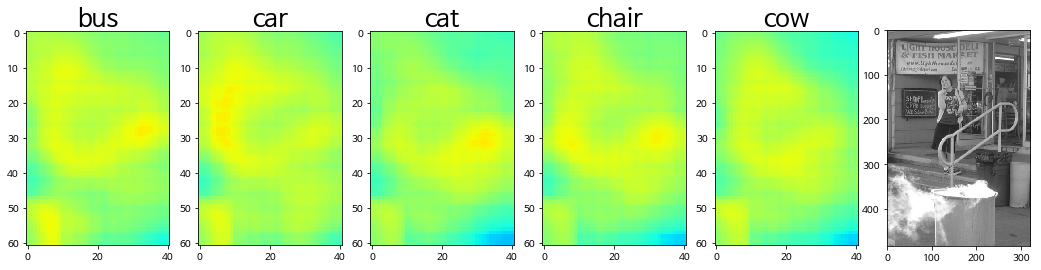

In [45]:
# Create figure and axes
fig = plt.figure(figsize=(18,7))
for i,p in enumerate(preds_dist[5:10,3]):
    ax = fig.add_subplot(1,6, i+1)
    imgplot = ax.imshow(p.cpu().numpy(), cmap='jet')
    imgplot.set_clim(0,1)
    font_title = {'family': 'NanumBarunGothic', 'size': 25, 'color': 'black'}
    plt.title(voc_classes[5:10][i], fontdict=font_title)
    
plt.subplot(1,6,6)
plt.imshow(frame[:,:,::-1])

# plt.subplot(2,4,8)
# _data = nn.UpsamplingNearest2d([224,224])(data)
# data_sobel = sobel(_data.cuda())
# plt.imshow(data_sobel[0][0].cpu().numpy(), cmap='gray')
# torchvision.utils.save_image(data_sobel, 'foo.jpg')

plt.show()

In [37]:
len(sobel_all)

2427

In [38]:
# save pickle data`
import pickle

n_train = 2427
hmaps = heat_all #torch.stack(heat_all).cpu().numpy().astype(np.float16)
data_train = {
    'heatmaps': hmaps[:n_train],
    'sobels': sobel_all[:n_train],
    'boxes': np.stack(box_yolo_all)[:n_train],
    'targets': np.stack(target_all)[:n_train],
}
data_val = {
    'heatmaps': hmaps[n_train:],
    'sobels': sobel_all[n_train:],
    'boxes': np.stack(box_yolo_all)[n_train:],
    'targets': np.stack(target_all)[n_train:],
}
pickle.dump(data_train, open("heatmap_voc_1218.pickle", 'wb'), protocol=4)
# pickle.dump(data_val, open("heatmap_voc_1128_val.pickle", 'wb'), protocol=4)

del hmaps

# # load
# with open('data.pickle', 'rb') as f:
#     data = pickle.load(f)

---
#  
#  
# Detecter Performance

In [11]:
# ------------- non max suppression -------------
# https://wns349.github.io/2018/10/16/nms/
from itertools import combinations, permutations

# Calc IOU
def calcIOU(box1, box2):
    """
    box - x,y,w,h
    """
    area_box1 = box1[2]*box1[3]
    area_box2 = box2[2]*box2[3]
    x1_max = max(box1[0], box2[0])
    x2_min = min(box1[0]+box1[2], box2[0]+box2[2])
    y1_max = max(box1[1], box2[1])
    y2_min = min(box1[1]+box1[3], box2[1]+box2[3])
    
    area_intersection = max(0, x2_min-x1_max) * max(0, y2_min-y1_max)
    area_union = area_box1+area_box2-area_intersection +1e-9
    return area_intersection/area_union

def non_max_sup_one_class(bboxes, threshold=0.2, descending=False):
    """
    @params threshold - 
    @params ascending - 기본이 내림차순,
    """
    bboxes = list(bboxes)
    bboxes.sort(key = lambda x: x[2], reverse=descending) # 거리값이므로 오름차순, 확률이면 내림차순  
    bboxes = np.array(bboxes)
    keeps = [True]*len(bboxes)

    for i, bbox in enumerate(bboxes):
        if not keeps[i]: continue
        for j in range(i+1, len(bboxes)):
            if not keeps[i]: continue
            iou_res = calcIOU(bbox[0], bboxes[j][0])
            if iou_res>threshold: keeps[j] = False
    return bboxes[keeps]

def rpn3(box, n_slice_x, n_slice_y):
    """
    n분할 rpn 조합
    @params box: x,y,w,h
    @params im: nomalized image tensor N x C x W x H
    @return 
    """
    w = box[2]/n_slice_x
    h = box[3]/n_slice_y
    
    rois = []
    boxes = []
    
    coords = np.array(np.meshgrid(list(range(n_slice_x+1)), list(range(n_slice_y+1)))).T.reshape(-1,2)
    
    for a,b in combinations(coords,2):
        if a[0]>=b[0] or a[1]>= b[1]: continue # 넓이 없는 사각형 제거
#         print(a,b)
        boxes.append([box[0]+a[0]*w, box[1]+a[1]*h, 
                      (b[0]-a[0])*w, (b[1]-a[1])*h]) # x,y,w,h

    boxes = torch.tensor(boxes)
    return boxes

def get_rois(images, featuremaps, bboxes, texture_mode=False, n_slice=3):
    """
    roi-align from feature map
    @params images - 원본 이미지 (사이즈 계산용)
    @params featuremaps - CNN Backbone 거쳐 나온 것
    @params bboxes - 원본 이미지에서의 bboxes (x,y,w,h)
    @return 피처맵에서 스케일된 bbox부분 7x7로 roi-align된 피처맵
    """
    # calc bbox ratio
    ratio_y = featuremaps.shape[2]/images.shape[2]
    ratio_x = featuremaps.shape[3]/images.shape[3]
    bboxes_scaled = bboxes.clone()#.detach()

    bboxes_scaled[:,0] = bboxes_scaled[:,0]*ratio_x # for x
    bboxes_scaled[:,1] = bboxes_scaled[:,1]*ratio_y # for y
    bboxes_scaled[:,2] = bboxes_scaled[:,2]*ratio_x # for w
    bboxes_scaled[:,3] = bboxes_scaled[:,3]*ratio_y # for h

    # x,y,w,h -> x1, y1, x2, y2 그래디언트 학습되는 변수가 아니므로 inplace 계산 들어가도 괜찮다
    bboxes_scaled[:, 2] = bboxes_scaled[:, 0] + bboxes_scaled[:, 2]
    bboxes_scaled[:, 3] = bboxes_scaled[:, 1] + bboxes_scaled[:, 3]
    
    crops = torchvision.ops.roi_align(featuremaps, [bboxes_scaled], [7,7])
    return crops

def box_cvt(box):
    """
    auto grad possable
    @params box - N x 4
    x,y,w,h --> x1,y1,x2,y2
    """
    box2 = box.clone().float()
    box2[:,0] = box[:,0]
    box2[:,1] = box[:,1]
    box2[:,2] = box[:,0] + box[:,2]
    box2[:,3] = box[:,1] + box[:,3]
    return box2

In [16]:
from sklearn.mixture import GaussianMixture
from sklearn.utils.testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning
import scipy.stats as stats
import math

def getOrdi(mask, boundary):
    """
    max/min x,y 좌표 구하기
    """
    mask_list = mask.tolist()
    mask_T_list = mask.T.tolist()
    # x1, y1, x2, y2
    x1 = float('inf')
    x2 = float('-inf')
    y1 = float('inf')
    y2 = float('-inf')

    for row in mask_list:
        try:
            xmin = row.index(boundary)
            xmax = len(row)-row[::-1].index(boundary)-1
            if x1>xmin: x1=xmin
            if x2<xmax: x2=xmax
        except: pass
    for row in mask_T_list:
        try:
            xmin = row.index(boundary)
            xmax = len(row)-row[::-1].index(boundary)-1
            if y1>xmin: y1=xmin
            if y2<xmax: y2=xmax        
        except: pass
    return x1, y1, x2, y2

def plotGMM(inputs, n_components=5, SHOW_PLOT=False):
    """
    inputs - preds_dist[c_idx]
    """
    X = inputs.flatten().reshape(-1,1).cpu()
    # fit GMM
    gmm = GaussianMixture(n_components=n_components, init_params='kmeans', random_state=0, tol=1e-9)#, max_iter=n)
    with ignore_warnings(category=ConvergenceWarning):
        gmm.fit(X)

    y=[]
    # ------------- get x-range 중요 ---------------
    i_max = gmm.means_.argmax()
    i_min = gmm.means_.argmin()
    mu_max = gmm.means_[i_max][0]
    std_max = math.sqrt(gmm.covariances_[i_max][0])
    mu_min = gmm.means_[i_min][0]
    std_min = math.sqrt(gmm.covariances_[i_min][0])
    x = np.linspace(mu_min - 3*std_min, mu_max + 3*std_max, 200)
    # ------------- get x-range 중요 ---------------
    for i in range(n_components):
        mu = gmm.means_[i][0]
        var = gmm.covariances_[i][0]
        sigma = math.sqrt(var)
#         x = np.linspace(0.3,0.9,200)
        y.append(stats.norm.pdf(x, mu, sigma)*gmm.weights_[i])
        plt.plot(x, y[i])
#         x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
#         y.append(x)
#         plt.plot(x, stats.norm.pdf(x, mu, sigma)*gmm.weights_[i])
    # find decision boundary
    k = gmm.predict(x.reshape(-1,1))
    idx = np.where(np.abs(k[1:]-k[:-1])!=0) # 두 responsibility가 교체되는 x값의 인덱스
#     print(np.abs(k[1:]-k[:-1])!=0, idx)
    boundaries = x[1:][idx]
#     # boundaries 가 여러개 나올 수 있는데 그 중 likelihood가 가장 높은 값의 인덱스 선택
#     b_idx = gmm.score_samples(boundaries.reshape(-1,1)).argmax()  
#     boundary = boundaries[b_idx]
    # boundaries 가 여러개 나올 수 있는데 그 중 score 0.05이상의 가장 큰 값 선택
    boundary = boundaries[gmm.score_samples(boundaries.reshape(-1,1))>np.log(0.1)][-1]
    plt.axvline(x=boundary, c='r') 
    
    if(SHOW_PLOT):
        print(boundaries, gmm.score_samples(boundaries.reshape(-1,1)))
        sns.distplot(inputs.flatten().cpu().numpy())
        plt.show()
    return round(boundary, 3), gmm

# _, gmm = plotGMM(preds_dist[targets_gt[0]], n_components=5, SHOW_PLOT=True)

import matplotlib.font_manager as fm

font_path = 'C:\\Windows\\Fonts\\NanumBarunGothic.ttf'
font_name = fm.FontProperties(fname=font_path, size=50).get_name()
print(font_name)
plt.rc('font', family=font_name)

# font setting
font_title = {'family': 'NanumBarunGothic', 'size': 18, 'color': 'black'}
font_label = {'family': 'NanumBarunGothic', 'size': 12, 'color': 'black'}

def textureDetectMultiChannel(featuremaps, stride=(1,1), upsample=False):
    """
    box maker
    batch N - featuremaps.shape[0]
    """
    boxes_t = []
    base_boxes = []
    esp = 1e-4
#     channels = [(1,1), (3,3), (5,5), (7,7)]
    channels = [(1,1),(2,1),(1,2), (3,3),(6,3),(3,6)]#, (5,5),(5,10),(10,5)]    
    # ------------------- 속도 최적화 필요 ----------------------
    # x,y 순서 바뀌면 안됨
    #     for filter_size in channels:
    y_range = np.arange(0,featuremaps.shape[2]-1+esp, stride[1])
    x_range = np.arange(0,featuremaps.shape[3]-1+esp, stride[0])
    for y in y_range:
        for x in x_range:
            xx = x+1/2
            yy = y+1/2
            xx2 = x+1/2
            yy2 = y+1/2
            base_boxes.append([xx,yy,xx2,yy2]) # x,y,x2,y2
    base_boxes = torch.tensor(base_boxes).data.cuda().float()
    
    for filter_size in channels:
        b = base_boxes.clone()
        b[:,0] = b[:,0]-filter_size[0]/2
        b[:,1] = b[:,1]-filter_size[1]/2
        b[:,2] = b[:,2]+filter_size[0]/2
        b[:,3] = b[:,3]+filter_size[1]/2
        boxes_t.append(b)
    boxes_t = torch.cat(boxes_t)
    # ------------------- 속도 최적화 필요 ----------------------
    
    print('<featuremaps-shape>', featuremaps.shape)
    crops = torchvision.ops.roi_align(featuremaps, [boxes_t]*featuremaps.shape[0], [1,1]).data
    print('<roi-align>', crops.squeeze().shape)
    
    # inference using cosine similarity via class mean vector
    preds_dist = my_cos(crops.squeeze(), model.embedded_means) # ch*h*w, cls
    print('<class, roi-shape>', preds_dist.shape, len(channels), len(y_range), len(x_range), '-->  (224,224)')
    preds_dist = preds_dist.transpose(1,0).reshape(-1, len(channels), len(y_range), len(x_range)) # cls, ch*h*w
    # upsampling to same size for batch process
    if(upsample):
        preds_dist = nn.UpsamplingBilinear2d([224,224])(preds_dist)
    print('[n_box]:', len(boxes_t))
    return preds_dist # cls,ch,h,w


def plotHeatMap(preds):
    fig = plt.figure(figsize=(20,15))
    for j in range(4):
        for i in range(8):
            n_fig = i+j*8+1
            if(n_fig==32):
                break
            a=fig.add_subplot(4,8,n_fig)
            imgplot = plt.imshow(preds_dist.cpu()[n_fig-1], cmap='jet')
            imgplot.set_clim(0,1)
            a.set_title(str(n_fig-1)+'//'+voc_val_dataset.classes[n_fig-1].split(' ')[0])
    plt.colorbar(ticks=[0.1,0.3,0.5,0.7,0.9], orientation ='horizontal')
    plt.show()
    return

def drawTextureRect(orig_fmap=None, fmap_box=None, box=None, n=4, filter_size=(3,3), stride=(.25, .25), isFirst=True, c=(0,0,255), EROSION=False):
    """
    filter_size - 클수록 멀리봄 
    stride - 작을수록 분해능 높음
    EROSION - 노이즈 제거
    """
    global featuremaps, frame
    """box maker"""
    if(isFirst):
        preds_dist = textureDetect(featuremaps, filter_size=filter_size, stride=stride)
        #     plotHeatMap(preds_dist)
    else:
        preds_dist = textureDetect(orig_fmap, filter_size=filter_size, stride=stride)
        #     plotHeatMap(preds_dist)

    print('<>', featuremaps.shape, preds_dist.shape)
    """use gmm"""
    boundary, gmm = plotGMM(preds_dist[targets_gt[0]], n_components=n, SHOW_PLOT=False)
    print('[boundary]:', boundary)

    mask = preds_dist[targets_gt[0]]
    mask = torch.where(mask>boundary, torch.zeros_like(mask).fill_(255), torch.zeros_like(mask))
    mask = mask.cpu().numpy()
    
    if(EROSION):
        kernel = np.ones(filter_size)
        mask = cv2.erode(mask.cpu().numpy(), kernel, iterations=3)
    
#     plt.imshow(mask)
#     plt.show()
    #     print(mask.shape)
    box = getOrdi(mask, 255) # x1, y1, x2, y2
    x1, y1, x2, y2 = box
    if(isFirst):
        r_y = frame.shape[0]/mask.shape[0]
        r_x = frame.shape[1]/mask.shape[1]
        x1*=r_x; x2*=r_x; y1*=r_y; y2*=r_y
    else:
        r_y = fmap_box[3]/mask.shape[0]
        r_x = fmap_box[2]/mask.shape[1]
        x1=fmap_box[0]+x1*r_x; x2=fmap_box[0]+x2*r_x; y1=fmap_box[1]+y1*r_y; y2=fmap_box[1]+y2*r_y
    try:
        print(boxes_gt, (int(x1), int(y1), int(x2-x1), int(y2-y1)))
        cv2.rectangle(frame, (int(x1), int(y1)), (int(x2), int(y2)), c, 1, cv2.LINE_AA)
        cv2.putText(frame, 'n:'+str(n), (int(x1)-3, int(y1)-12), cv2.FONT_HERSHEY_SIMPLEX, .5, (50,50,50), 1)
    except: pass
    return (x1,y1,x2-x1,y2-y1), preds_dist # xywh


NanumBarunGothic


In [18]:
def cvt_yolobox(bboxes_yolo, size):
    """
    size - original [w,h]
    np.array
    yolo(cx,cy,w,h) to x,y,w,h
    """
    bboxes = bboxes_yolo.copy() # x,y,w,h

    bboxes[:,0] = (bboxes_yolo[:,0] - bboxes_yolo[:,2]/2)*size[1] # x
    bboxes[:,1] = (bboxes_yolo[:,1] - bboxes_yolo[:,3]/2)*size[0] # y
    bboxes[:,2] = bboxes_yolo[:,2]*size[1]
    bboxes[:,3] = bboxes_yolo[:,3]*size[0]
    bboxes = bboxes.astype(np.int)
    return bboxes

class Sobel(torch.nn.Module):
    def __init__(self):
        super(Sobel, self).__init__()
        sobel_x=torch.tensor([[-1, 0, 1],[-2,0,2],[-1,0,1]]).float().unsqueeze(0).unsqueeze(0)
        self.conv1=nn.Conv2d(1,1, kernel_size=3, stride=1, padding=1, bias=False)
        self.conv1.weight=nn.Parameter(sobel_x)
        
        sobel_y=torch.tensor([[1, 2, 1],[0,0,0],[-1,-2,-1]]).float().unsqueeze(0).unsqueeze(0)
        self.conv2=nn.Conv2d(1,1, kernel_size=3, stride=1, padding=1, bias=False)
        self.conv2.weight=nn.Parameter(sobel_y)
        
        self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        
    def forward(self, x):
        """
        x - b,3ch(R,G,B),h,w
        return - b,1,h,w
        """
        # RGB to gray
        r, g, b = torch.chunk(x, chunks=3, dim=-3)
        gray = 0.299 * r + 0.587 * g + 0.110 * b

        G_x=self.conv1(gray).data
        G_y=self.conv2(gray).data

        G=torch.sqrt(torch.pow(G_x,2)+ torch.pow(G_y,2))
        return G
    
class Flatten(torch.nn.Module):
    """
    torch.nn.Sequential에서 사용가능한 flatten 모듈
    """
    def forward(self, x):
        batch_size = x.shape[0]
        return x.view(batch_size, -1)


class Bottleneck(nn.Module):
    def __init__(self, inchannel, outchannel, dilation=1, downsample=False):
        super(Bottleneck, self).__init__()
        self.downsample = downsample
        
        self.conv1 = nn.Conv2d(inchannel, inchannel, kernel_size=(1,1), stride=(1, 1))
        self.bn1 = nn.BatchNorm2d(inchannel, eps=1e-05, momentum=0.1, affine=True)
        self.conv2 = nn.Conv2d(inchannel, inchannel, kernel_size=(3,3), stride=(1, 1), padding=dilation, dilation=dilation)
        self.bn2 = nn.BatchNorm2d(inchannel, eps=1e-05, momentum=0.1, affine=True)
        self.conv3 = nn.Conv2d(inchannel, outchannel, kernel_size=(1,1), stride=(1, 1))
        self.bn3 = nn.BatchNorm2d(outchannel, eps=1e-05, momentum=0.1, affine=True)
        self.pool = nn.MaxPool2d(2,2)
        self.relu = nn.ReLU()
        self.identity_conv = nn.Conv2d(1, outchannel, kernel_size=(1,1), stride=(1, 1))
        
        self.net = nn.Sequential(
            self.conv1,
            self.bn1,
            nn.ReLU(),
            self.conv2,
            self.bn2,
            nn.ReLU(),
            self.conv3,
            self.bn3,
        )
        
    def forward(self, x):
        identity = self.identity_conv(x[:,3:4]) # b*cls,edge_ch,224,224
        out = self.net(x)
        if(self.downsample):
            identity = self.pool(identity)
            out = self.pool(out)
        out += identity
        out = self.relu(out)
        return out
        
        
class BoxMaker(nn.Module):
    def __init__(self):
        super(BoxMaker, self).__init__()
        avg_pool = torch.nn.AdaptiveAvgPool2d(output_size=(1, 1))
        flatten = Flatten()
        self.roi_upsample = nn.UpsamplingBilinear2d([224,224])
        
        # backbone layer
        self.backbone = nn.Sequential(
            # 1x1 conv
            nn.Conv2d(6, 32, kernel_size=(3,3), stride=(1, 1), padding=(1,1)),
            nn.BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(32, 64, kernel_size=(3,3), stride=(1, 1), padding=(1,1)),
            nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(64, 128, kernel_size=(3,3), stride=(1, 1), padding=(1,1)),
            nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(128, 256, kernel_size=(3,3), stride=(1, 1), padding=(1,1)),
            nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True),
            nn.ReLU(), # n x 256 x 24 x 24
            avg_pool, # n x 256 x 1 x 1
            flatten, # n x 256
        )
        
        self.backbone2 = nn.Sequential(
            # 1x1 conv
            nn.Conv2d(6, 32, kernel_size=(3,3), stride=(1, 1), padding=(2,2), dilation=2),
            nn.BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(32, 64, kernel_size=(3,3), stride=(1, 1), padding=(2,2), dilation=2),
            nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(64, 128, kernel_size=(3,3), stride=(1, 1), padding=(2,2), dilation=2),
            nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(128, 256, kernel_size=(3,3), stride=(1, 1), padding=(2,2), dilation=2),
            nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True),
            nn.ReLU(), # n x 256 x 24 x 24
            avg_pool, # n x 256 x 1 x 1
            flatten, # n x 256
        )
        
        self.multihead_attn = nn.MultiheadAttention(embed_dim=512, num_heads=8)
                
        # fc layer
        self.fc = nn.Sequential(
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, 32),
            nn.ReLU(),
            nn.Linear(32, 5), # score_logit + cx,cy,w,h
        )
        
        self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

        
    def forward(self, inputs):
        """
        inputs - b,cls,ch,224,224
        """
        n_batch = inputs.shape[0] # b
        n_channel = inputs.shape[2] # ch
        # CNN backbone
        images = inputs.transpose(0,1).reshape(-1,n_channel,224,224) # b*cls,ch,224,224
        
        hh = self.backbone(images) # b*cls,256 
        hh2 = self.backbone2(images) # b*cls,256 
        hh3 = torch.cat([hh,hh2], dim=1) #b*cls,512
        hh3 = hh3.reshape(-1, n_batch, 512) # cls,b,512
        
        attn_output, attn_output_weights = self.multihead_attn(hh3, hh3, hh3) # q,k,v - L,N,E - cls,b,512        
        attn_sum = hh3+attn_output # cls,b,512
        
        res = attn_sum.transpose(0,1) # b,cls,512
#         res = hh3.transpose(0,1) # b,cls,512

        res2 = res.reshape(-1,512) # b*cls,512
        
        pp = self.fc(res2) # b*cls,5(1+4)
        pp = pp.reshape(n_batch,-1,5) # b,cls,5(1+4)
        logit = pp[:,:,0] # b,cls
        coords = pp[:,:,1:] # b,cls,4
        
        return logit, coords

sobel = Sobel()
sobel.to(sobel.device)
boxMaker = BoxMaker()
boxMaker.to(boxMaker.device)
# boxMaker.load_state_dict(torch.load('torch_models/heatmap-6chan-1223-no-attn.pth', map_location='cuda:0'))
boxMaker.load_state_dict(torch.load('torch_models/heatmap-6chan-1216.pth', map_location='cuda:0'))
boxMaker.eval()

BoxMaker(
  (roi_upsample): UpsamplingBilinear2d(size=[224, 224], mode=bilinear)
  (backbone): Sequential(
    (0): Conv2d(6, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): BatchNorm2

In [28]:
import time
#  ref - floor, frontview, office // val - floor2, frontview2, wall
# validation_21, reference_21_train // reference_21_val // all_10
# 21 10 바꾸기 주의, MyDataset도 바꿔야함 -10 해야함
root_dir = '.\\yolo_mark_image\\reference_21_train'
class_path = '.\\yolo_mark_image\\obj_21.names'

# ---------------------------- val set 로드 ---------------------------------
voc_val_dataset = MyDataset(root_dir, class_path, 
        transform=transforms.Compose([
        transforms.ToTensor()
    ]))

voc_transform = transforms.Compose([
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
# assert val_dataset.classes==sample_dir_list, "샘플링 클래스와 데이터로더 클래스가 다름"
# ---------------------------- val set 정확도 측정 ---------------------------------

fps=0
SHOW_IMAGE = False # 이미지 볼지 말지
# target_all = [] #ground truth bboxs`
# heat_all = []
# box_yolo_all = []
# sobel_all = []

# print('[num_class]:', len(sample_dir_list), sample_dir_list)
for i in tqdm(np.random.permutation(len(voc_val_dataset))):
# for i in tqdm(range(len(voc_val_dataset))):
    startTime = time.time()
    data, targets_gt, boxes_gt, boxes_gt_yolo = voc_val_dataset[i] # 정답 데이터, 레이블, bbox

    frame = data.clone().detach().mul(255).squeeze().numpy().astype(np.uint8).transpose([1,2,0])
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB) # opencv image need to convert BGR -> RGB

    im_tensor = voc_transform(data.squeeze()).to(model.device).data.unsqueeze(0)
    featuremaps = model(im_tensor)

    _data = nn.UpsamplingNearest2d([224,224])(data)
    data_sobel = sobel(_data.cuda())
    
    preds_dist = textureDetectMultiChannel(featuremaps, stride=(0.25, 0.25))
    sobel_all.append(data_sobel[0].cpu().data)
    heat_all.append(preds_dist.cpu().data) # heatmap
    box_yolo_all.append(boxes_gt_yolo)
    target_all.append(targets_gt)
        
    # only render UI
    if SHOW_IMAGE:
        # frame = cv2.resize(frame, (int(frame.shape[1]*1.5), int(frame.shape[0]*1.5)), interpolation=cv2.INTER_CUBIC)
        cv2.imshow('frame',frame)
        k = cv2.waitKey(0) & 0xff 
        if k == 27: # esc
            break

    endTime = time.time()
    fps = int(1/(endTime - startTime))
    
cv2.destroyAllWindows()

A Jupyter Widget

<featuremaps-shape> torch.Size([1, 2048, 12, 20])
<roi-align> torch.Size([31185, 2048])
<class, roi-shape> torch.Size([31185, 21]) 9 45 77 -->  (224,224)
[n_box]: 31185
<featuremaps-shape> torch.Size([1, 2048, 12, 20])
<roi-align> torch.Size([31185, 2048])
<class, roi-shape> torch.Size([31185, 21]) 9 45 77 -->  (224,224)
[n_box]: 31185
<featuremaps-shape> torch.Size([1, 2048, 30, 17])
<roi-align> torch.Size([68445, 2048])
<class, roi-shape> torch.Size([68445, 21]) 9 117 65 -->  (224,224)
[n_box]: 68445
<featuremaps-shape> torch.Size([1, 2048, 12, 20])
<roi-align> torch.Size([31185, 2048])
<class, roi-shape> torch.Size([31185, 21]) 9 45 77 -->  (224,224)
[n_box]: 31185
<featuremaps-shape> torch.Size([1, 2048, 30, 17])
<roi-align> torch.Size([68445, 2048])
<class, roi-shape> torch.Size([68445, 21]) 9 117 65 -->  (224,224)
[n_box]: 68445
<featuremaps-shape> torch.Size([1, 2048, 30, 17])
<roi-align> torch.Size([68445, 2048])
<class, roi-shape> torch.Size([68445, 21]) 9 117 65 -->  (224,224

<class, roi-shape> torch.Size([68445, 21]) 9 117 65 -->  (224,224)
[n_box]: 68445
<featuremaps-shape> torch.Size([1, 2048, 12, 20])
<roi-align> torch.Size([31185, 2048])
<class, roi-shape> torch.Size([31185, 21]) 9 45 77 -->  (224,224)
[n_box]: 31185
<featuremaps-shape> torch.Size([1, 2048, 30, 17])
<roi-align> torch.Size([68445, 2048])
<class, roi-shape> torch.Size([68445, 21]) 9 117 65 -->  (224,224)
[n_box]: 68445
<featuremaps-shape> torch.Size([1, 2048, 12, 20])
<roi-align> torch.Size([31185, 2048])
<class, roi-shape> torch.Size([31185, 21]) 9 45 77 -->  (224,224)
[n_box]: 31185
<featuremaps-shape> torch.Size([1, 2048, 30, 17])
<roi-align> torch.Size([68445, 2048])
<class, roi-shape> torch.Size([68445, 21]) 9 117 65 -->  (224,224)
[n_box]: 68445
<featuremaps-shape> torch.Size([1, 2048, 30, 17])
<roi-align> torch.Size([68445, 2048])
<class, roi-shape> torch.Size([68445, 21]) 9 117 65 -->  (224,224)
[n_box]: 68445
<featuremaps-shape> torch.Size([1, 2048, 12, 20])
<roi-align> torch.Si

<class, roi-shape> torch.Size([31185, 21]) 9 45 77 -->  (224,224)
[n_box]: 31185
<featuremaps-shape> torch.Size([1, 2048, 12, 20])
<roi-align> torch.Size([31185, 2048])
<class, roi-shape> torch.Size([31185, 21]) 9 45 77 -->  (224,224)
[n_box]: 31185
<featuremaps-shape> torch.Size([1, 2048, 30, 17])
<roi-align> torch.Size([68445, 2048])
<class, roi-shape> torch.Size([68445, 21]) 9 117 65 -->  (224,224)
[n_box]: 68445
<featuremaps-shape> torch.Size([1, 2048, 17, 30])
<roi-align> torch.Size([68445, 2048])
<class, roi-shape> torch.Size([68445, 21]) 9 65 117 -->  (224,224)
[n_box]: 68445
<featuremaps-shape> torch.Size([1, 2048, 30, 17])
<roi-align> torch.Size([68445, 2048])
<class, roi-shape> torch.Size([68445, 21]) 9 117 65 -->  (224,224)
[n_box]: 68445
<featuremaps-shape> torch.Size([1, 2048, 12, 20])
<roi-align> torch.Size([31185, 2048])
<class, roi-shape> torch.Size([31185, 21]) 9 45 77 -->  (224,224)
[n_box]: 31185
<featuremaps-shape> torch.Size([1, 2048, 12, 20])
<roi-align> torch.Siz

<class, roi-shape> torch.Size([68445, 21]) 9 117 65 -->  (224,224)
[n_box]: 68445
<featuremaps-shape> torch.Size([1, 2048, 12, 20])
<roi-align> torch.Size([31185, 2048])
<class, roi-shape> torch.Size([31185, 21]) 9 45 77 -->  (224,224)
[n_box]: 31185
<featuremaps-shape> torch.Size([1, 2048, 30, 17])
<roi-align> torch.Size([68445, 2048])
<class, roi-shape> torch.Size([68445, 21]) 9 117 65 -->  (224,224)
[n_box]: 68445
<featuremaps-shape> torch.Size([1, 2048, 12, 20])
<roi-align> torch.Size([31185, 2048])
<class, roi-shape> torch.Size([31185, 21]) 9 45 77 -->  (224,224)
[n_box]: 31185
<featuremaps-shape> torch.Size([1, 2048, 12, 20])
<roi-align> torch.Size([31185, 2048])
<class, roi-shape> torch.Size([31185, 21]) 9 45 77 -->  (224,224)
[n_box]: 31185
<featuremaps-shape> torch.Size([1, 2048, 30, 17])
<roi-align> torch.Size([68445, 2048])
<class, roi-shape> torch.Size([68445, 21]) 9 117 65 -->  (224,224)
[n_box]: 68445
<featuremaps-shape> torch.Size([1, 2048, 12, 20])
<roi-align> torch.Siz

<class, roi-shape> torch.Size([31185, 21]) 9 45 77 -->  (224,224)
[n_box]: 31185
<featuremaps-shape> torch.Size([1, 2048, 12, 20])
<roi-align> torch.Size([31185, 2048])
<class, roi-shape> torch.Size([31185, 21]) 9 45 77 -->  (224,224)
[n_box]: 31185
<featuremaps-shape> torch.Size([1, 2048, 12, 20])
<roi-align> torch.Size([31185, 2048])
<class, roi-shape> torch.Size([31185, 21]) 9 45 77 -->  (224,224)
[n_box]: 31185
<featuremaps-shape> torch.Size([1, 2048, 30, 17])
<roi-align> torch.Size([68445, 2048])
<class, roi-shape> torch.Size([68445, 21]) 9 117 65 -->  (224,224)
[n_box]: 68445
<featuremaps-shape> torch.Size([1, 2048, 30, 17])
<roi-align> torch.Size([68445, 2048])
<class, roi-shape> torch.Size([68445, 21]) 9 117 65 -->  (224,224)
[n_box]: 68445
<featuremaps-shape> torch.Size([1, 2048, 15, 20])
<roi-align> torch.Size([39501, 2048])
<class, roi-shape> torch.Size([39501, 21]) 9 57 77 -->  (224,224)
[n_box]: 39501
<featuremaps-shape> torch.Size([1, 2048, 30, 17])
<roi-align> torch.Size

<class, roi-shape> torch.Size([68445, 21]) 9 117 65 -->  (224,224)
[n_box]: 68445
<featuremaps-shape> torch.Size([1, 2048, 30, 17])
<roi-align> torch.Size([68445, 2048])
<class, roi-shape> torch.Size([68445, 21]) 9 117 65 -->  (224,224)
[n_box]: 68445
<featuremaps-shape> torch.Size([1, 2048, 30, 17])
<roi-align> torch.Size([68445, 2048])
<class, roi-shape> torch.Size([68445, 21]) 9 117 65 -->  (224,224)
[n_box]: 68445
<featuremaps-shape> torch.Size([1, 2048, 30, 17])
<roi-align> torch.Size([68445, 2048])
<class, roi-shape> torch.Size([68445, 21]) 9 117 65 -->  (224,224)
[n_box]: 68445
<featuremaps-shape> torch.Size([1, 2048, 12, 20])
<roi-align> torch.Size([31185, 2048])
<class, roi-shape> torch.Size([31185, 21]) 9 45 77 -->  (224,224)
[n_box]: 31185
<featuremaps-shape> torch.Size([1, 2048, 30, 17])
<roi-align> torch.Size([68445, 2048])
<class, roi-shape> torch.Size([68445, 21]) 9 117 65 -->  (224,224)
[n_box]: 68445
<featuremaps-shape> torch.Size([1, 2048, 12, 20])
<roi-align> torch.S

<class, roi-shape> torch.Size([68445, 21]) 9 117 65 -->  (224,224)
[n_box]: 68445
<featuremaps-shape> torch.Size([1, 2048, 17, 30])
<roi-align> torch.Size([68445, 2048])
<class, roi-shape> torch.Size([68445, 21]) 9 65 117 -->  (224,224)
[n_box]: 68445
<featuremaps-shape> torch.Size([1, 2048, 12, 20])
<roi-align> torch.Size([31185, 2048])
<class, roi-shape> torch.Size([31185, 21]) 9 45 77 -->  (224,224)
[n_box]: 31185
<featuremaps-shape> torch.Size([1, 2048, 30, 17])
<roi-align> torch.Size([68445, 2048])
<class, roi-shape> torch.Size([68445, 21]) 9 117 65 -->  (224,224)
[n_box]: 68445
<featuremaps-shape> torch.Size([1, 2048, 30, 17])
<roi-align> torch.Size([68445, 2048])
<class, roi-shape> torch.Size([68445, 21]) 9 117 65 -->  (224,224)
[n_box]: 68445
<featuremaps-shape> torch.Size([1, 2048, 12, 20])
<roi-align> torch.Size([31185, 2048])
<class, roi-shape> torch.Size([31185, 21]) 9 45 77 -->  (224,224)
[n_box]: 31185
<featuremaps-shape> torch.Size([1, 2048, 12, 20])
<roi-align> torch.Si

<class, roi-shape> torch.Size([31185, 21]) 9 45 77 -->  (224,224)
[n_box]: 31185
<featuremaps-shape> torch.Size([1, 2048, 12, 20])
<roi-align> torch.Size([31185, 2048])
<class, roi-shape> torch.Size([31185, 21]) 9 45 77 -->  (224,224)
[n_box]: 31185
<featuremaps-shape> torch.Size([1, 2048, 17, 30])
<roi-align> torch.Size([68445, 2048])
<class, roi-shape> torch.Size([68445, 21]) 9 65 117 -->  (224,224)
[n_box]: 68445
<featuremaps-shape> torch.Size([1, 2048, 30, 17])
<roi-align> torch.Size([68445, 2048])
<class, roi-shape> torch.Size([68445, 21]) 9 117 65 -->  (224,224)
[n_box]: 68445
<featuremaps-shape> torch.Size([1, 2048, 12, 20])
<roi-align> torch.Size([31185, 2048])
<class, roi-shape> torch.Size([31185, 21]) 9 45 77 -->  (224,224)
[n_box]: 31185
<featuremaps-shape> torch.Size([1, 2048, 12, 20])
<roi-align> torch.Size([31185, 2048])
<class, roi-shape> torch.Size([31185, 21]) 9 45 77 -->  (224,224)
[n_box]: 31185
<featuremaps-shape> torch.Size([1, 2048, 30, 17])
<roi-align> torch.Size

<class, roi-shape> torch.Size([68445, 21]) 9 65 117 -->  (224,224)
[n_box]: 68445
<featuremaps-shape> torch.Size([1, 2048, 30, 17])
<roi-align> torch.Size([68445, 2048])
<class, roi-shape> torch.Size([68445, 21]) 9 117 65 -->  (224,224)
[n_box]: 68445
<featuremaps-shape> torch.Size([1, 2048, 30, 17])
<roi-align> torch.Size([68445, 2048])
<class, roi-shape> torch.Size([68445, 21]) 9 117 65 -->  (224,224)
[n_box]: 68445
<featuremaps-shape> torch.Size([1, 2048, 30, 17])
<roi-align> torch.Size([68445, 2048])
<class, roi-shape> torch.Size([68445, 21]) 9 117 65 -->  (224,224)
[n_box]: 68445
<featuremaps-shape> torch.Size([1, 2048, 30, 17])
<roi-align> torch.Size([68445, 2048])
<class, roi-shape> torch.Size([68445, 21]) 9 117 65 -->  (224,224)
[n_box]: 68445
<featuremaps-shape> torch.Size([1, 2048, 30, 17])
<roi-align> torch.Size([68445, 2048])
<class, roi-shape> torch.Size([68445, 21]) 9 117 65 -->  (224,224)
[n_box]: 68445
<featuremaps-shape> torch.Size([1, 2048, 30, 17])
<roi-align> torch.

<class, roi-shape> torch.Size([68445, 21]) 9 117 65 -->  (224,224)
[n_box]: 68445
<featuremaps-shape> torch.Size([1, 2048, 12, 20])
<roi-align> torch.Size([31185, 2048])
<class, roi-shape> torch.Size([31185, 21]) 9 45 77 -->  (224,224)
[n_box]: 31185
<featuremaps-shape> torch.Size([1, 2048, 30, 17])
<roi-align> torch.Size([68445, 2048])
<class, roi-shape> torch.Size([68445, 21]) 9 117 65 -->  (224,224)
[n_box]: 68445
<featuremaps-shape> torch.Size([1, 2048, 30, 17])
<roi-align> torch.Size([68445, 2048])
<class, roi-shape> torch.Size([68445, 21]) 9 117 65 -->  (224,224)
[n_box]: 68445
<featuremaps-shape> torch.Size([1, 2048, 12, 20])
<roi-align> torch.Size([31185, 2048])
<class, roi-shape> torch.Size([31185, 21]) 9 45 77 -->  (224,224)
[n_box]: 31185
<featuremaps-shape> torch.Size([1, 2048, 12, 20])
<roi-align> torch.Size([31185, 2048])
<class, roi-shape> torch.Size([31185, 21]) 9 45 77 -->  (224,224)
[n_box]: 31185
<featuremaps-shape> torch.Size([1, 2048, 12, 20])
<roi-align> torch.Siz

In [ ]:
a = []
for b in box_yolo_all:
    x,y,w,h = b[0]
    a.append(w*h)

aa=pd.Series(a)
aa.describe()

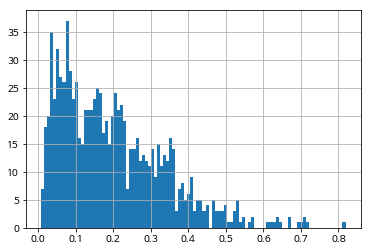

In [29]:
aa.hist(bins=100)
plt.show()

In [41]:
import time
#  ref - floor, frontview, office // val - floor2, frontview2, wall
# validation_21, reference_21_train // reference_21_val // all_10
# 21 10 바꾸기 주의, MyDataset도 바꿔야함 -10 해야함
root_dir = '.\\yolo_mark_image\\validation_21'
class_path = '.\\yolo_mark_image\\obj_21.names'

# ---------------------------- val set 로드 ---------------------------------
voc_val_dataset = MyDataset(root_dir, class_path, 
        transform=transforms.Compose([
        transforms.ToTensor()
    ]))

voc_transform = transforms.Compose([
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
# assert val_dataset.classes==sample_dir_list, "샘플링 클래스와 데이터로더 클래스가 다름"
# ---------------------------- val set 정확도 측정 ---------------------------------

fps=0
SHOW_IMAGE = False # 이미지 볼지 말지
# target_all = [] #ground truth bboxs`
# heat_all = []
# box_yolo_all = []
# sobel_all = []

# print('[num_class]:', len(sample_dir_list), sample_dir_list)
for i in tqdm(np.random.permutation(len(voc_val_dataset))):
# for i in tqdm(range(len(voc_val_dataset))):
    startTime = time.time()
    data, targets_gt, boxes_gt, boxes_gt_yolo = voc_val_dataset[i] # 정답 데이터, 레이블, bbox

    frame = data.clone().detach().mul(255).squeeze().numpy().astype(np.uint8).transpose([1,2,0])
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB) # opencv image need to convert BGR -> RGB

    im_tensor = voc_transform(data.squeeze()).to(model.device).data.unsqueeze(0)
    featuremaps = model(im_tensor)

    _data = nn.UpsamplingNearest2d([224,224])(data)
    data_sobel = sobel(_data.cuda())
    
    preds_dist = textureDetectMultiChannel(featuremaps, stride=(0.25, 0.25), upsample=False)
    sobel_all.append(data_sobel[0].cpu().data)
    heat_all.append(preds_dist.cpu().data) # heatmap
    box_yolo_all.append(boxes_gt_yolo)
    target_all.append(targets_gt)
        
    # only render UI
    if SHOW_IMAGE:
        # frame = cv2.resize(frame, (int(frame.shape[1]*1.5), int(frame.shape[0]*1.5)), interpolation=cv2.INTER_CUBIC)
        cv2.imshow('frame',frame)
        k = cv2.waitKey(0) & 0xff 
        if k == 27: # esc
            break

    endTime = time.time()
    fps = int(1/(endTime - startTime))
    
cv2.destroyAllWindows()

A Jupyter Widget

<featuremaps-shape> torch.Size([1, 2048, 30, 17])
<roi-align> torch.Size([68445, 2048])
<class, roi-shape> torch.Size([68445, 10]) 9 117 65 -->  (224,224)
[n_box]: 68445



NameError: name 'sobel_all' is not defined

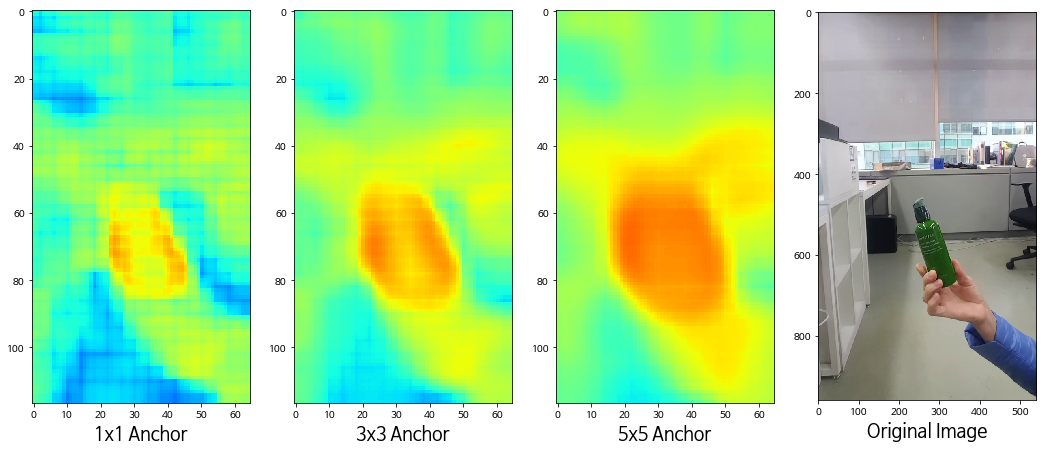

In [51]:
lab = ['1x1 Anchor', '3x3 Anchor', '5x5 Anchor', 'Original Image']
font_title = {'size': 18, 'color': 'black'}
# Create figure and axes
fig = plt.figure(figsize=(18,10))
for i,p in enumerate(preds_dist[0]):
    if(i%3>0): continue
    ax = fig.add_subplot(1,4, i//3+1)
    imgplot = ax.imshow(p.cpu().numpy(), cmap='jet')
    imgplot.set_clim(0,1)
    plt.xlabel(lab[i//3], fontdict=font_title)
    
plt.subplot(1,4,4)
plt.imshow(frame[:,:,::-1])
plt.xlabel(lab[-1], fontdict=font_title)

# plt.subplot(2,4,8)
# _data = nn.UpsamplingNearest2d([224,224])(data)
# data_sobel = sobel(_data.cuda())
# plt.imshow(data_sobel[0][0].cpu().numpy(), cmap='gray')
# torchvision.utils.save_image(data_sobel, 'foo.jpg')
plt.show()

In [21]:
# Create figure and axes
plt.figure(figsize=(12,8))
for i,p in enumerate(preds_dist[0]):
    plt.subplot(2,4,i+1)
    plt.imshow(p.cpu().numpy(), cmap='jet')
    
plt.subplot(2,4,7)
plt.imshow(frame[:,:,::-1])

plt.subplot(2,4,8)
_data = nn.UpsamplingNearest2d([224,224])(data)
data_sobel = sobel(_data.cuda())
plt.imshow(data_sobel[0][0].cpu().numpy(), cmap='gray')
torchvision.utils.save_image(data_sobel, 'foo.jpg')
plt.show()

ValueError: num must be 1 <= num <= 8, not 9

In [18]:
torchvision.utils.save_image(_data, 'foo.jpg')

In [29]:
len(sobel_all)

1903

In [30]:
# save pickle data
import pickle

hmaps = heat_all
data_train = {
    'heatmaps': hmaps,
    'sobels': sobel_all,
    'boxes': np.stack(box_yolo_all),
    'targets': np.stack(target_all),
}

pickle.dump(data_train, open("heatmap_21_1218.pickle", 'wb'), protocol=4)

del hmaps

In [26]:
# save pickle data
import pickle

hmaps = heat_all
data_val = {
    'heatmaps': hmaps,
    'sobels': sobel_all,
    'boxes': np.stack(box_yolo_all),
    'targets': np.stack(target_all),
}
pickle.dump(data_val, open("heatmap_21_1218_val.pickle", 'wb'), protocol=4)


---
#  
#  
# Show detection result

In [14]:
def concatSobel(preds_dist, data):
    """
    기존 히트맵 채널들과 sobel edge채널 합치기
    preds_dist - cls,ch,h,w
    data - b,3(RGB),h,w
    return - cls,ch+1,h,w
    """
    _data = nn.UpsamplingNearest2d([224,224])(data)
    data_sobel = sobel(_data.cuda())
    k = torch.stack([data_sobel[0]]*preds_dist.shape[0])
    return torch.cat([preds_dist, k], dim=1)

# concatSobel(preds_dist, data).shape

In [21]:
# show image
import time
#  ref - floor, frontview, office // val - floor2, frontview2, wall
# validation_21, reference_21_train // reference_21_val // all_10
# 21 10 바꾸기 주의, MyDataset도 바꿔야함 -10 해야함
root_dir = '.\\yolo_mark_image\\all_10'
class_path = '.\\yolo_mark_image\\obj_10.names'
# root_dir = '.\\yolo_mark_image\\reference_21'
# class_path = '.\\yolo_mark_image\\obj_21.names'


# ---------------------------- val set 로드 ---------------------------------
voc_val_dataset = MyDataset(root_dir, class_path, 
        transform=transforms.Compose([
        transforms.ToTensor()
    ]))

voc_transform = transforms.Compose([
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
# assert val_dataset.classes==sample_dir_list, "샘플링 클래스와 데이터로더 클래스가 다름"
# -----------------------`----- val set 정확도 측정 ---------------------------------

fps=0
SHOW_IMAGE = True # 이미지 볼지 말지

# print('[num_class]:', len(sample_dir_list), sample_dir_list)
for i in tqdm(np.random.permutation(len(voc_val_dataset))):
# for i in tqdm(range(len(voc_val_dataset))):
    startTime = time.time()
    data, targets_gt, boxes_gt, boxes_gt_yolo = voc_val_dataset[i] # 정답 데이터, 레이블, bbox

    frame = data.clone().detach().mul(255).squeeze().numpy().astype(np.uint8).transpose([1,2,0])
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB) # opencv image need to convert BGR -> RGB

    im_tensor = voc_transform(data.squeeze()).to(model.device).data.unsqueeze(0)
    featuremaps = model(im_tensor)

#     preds_dist = textureDetect(featuremaps, filter_size=(3,3), stride=(0.125, 0.125))
#     preds_dist = textureDetect(featuremaps, filter_size=(3,3), stride=(0.33, 0.33), upsample=True)
    preds_dist = textureDetectMultiChannel(featuremaps, stride=(0.25, 0.25), upsample=True)
    
#     box1, preds_dist = drawTextureRect(n=4, isFirst=True, filter_size=(3,3), stride=(0.33, 0.33))
#     box11, preds_dist = drawTextureRect(n=4, isFirst=True, filter_size=(3,3), stride=(2,2), c=(200,200,255))
    
#     plotHeatMap(preds_dist)
#     # my model

#     logit, boxes_adj = boxMaker(concatSobel(preds_dist, data).unsqueeze(0).data)
    logit, boxes_adj = boxMaker(preds_dist.unsqueeze(0).data)
    pred_d, pred = torch.max(logit, 1)
    print('[Logit]', pred_d.float().sigmoid().item())
    boxes_adj = cvt_yolobox(boxes_adj[:,pred.item()].detach().cpu().numpy(), frame.shape[:2])
    iou = torchvision.ops.box_iou(box_cvt(torch.tensor(boxes_gt).cuda()), 
                        box_cvt(torch.tensor(boxes_adj).cuda())).item()
    print('[IOU]', iou)
    isRight = pred.item()==targets_gt[0]
    res = str(isRight)+' [GT]:'+str(targets_gt[0])+' [Pred]:'+str(pred.item())+' - '+str(pred_d.float().sigmoid().item())[:5]
    print(res)  
    
    gx,gy,gw,gh = boxes_gt[0]
    x,y,w,h = boxes_adj[0]
    cv2.rectangle(frame, (gx,gy), (gx+gw, gy+gh), (255, 0, 0), 1, cv2.LINE_AA)     
    if(isRight): # label 맞춤
        if(iou>0.5): # IOU도 기준 이상 - green
            cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 1, cv2.LINE_AA)     
            cv2.putText(frame, res, (x-3, y-10), cv2.FONT_HERSHEY_SIMPLEX, .5, (0,255,0), 2)
            cv2.putText(frame, '[IOU]: '+str(iou)[:6], (x-3, y-28), cv2.FONT_HERSHEY_SIMPLEX, .5, (0,255,0), 2)         
        else: # IOU기준 이하 - yello
            cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 255), 1, cv2.LINE_AA)     
            cv2.putText(frame, res, (x-3, y-10), cv2.FONT_HERSHEY_SIMPLEX, .5, (0,255,255), 2)
            cv2.putText(frame, '[IOU]: '+str(iou)[:6], (x-3, y-28), cv2.FONT_HERSHEY_SIMPLEX, .5, (0,255,255), 2)            
    else: # label 틀림 - red
        cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 0, 255), 1, cv2.LINE_AA)     
        cv2.putText(frame, res, (x-3, y-10), cv2.FONT_HERSHEY_SIMPLEX, .5, (0,0,255), 2)
        cv2.putText(frame, '[IOU]: '+str(iou)[:6], (x-3, y-28), cv2.FONT_HERSHEY_SIMPLEX, .5, (0,0,255), 2)
    
    # only render UI
    if SHOW_IMAGE:
        # frame = cv2.resize(frame, (int(frame.shape[1]*1.5), int(frame.shape[0]*1.5)), interpolation=cv2.INTER_CUBIC)
        cv2.imshow('frame',frame)
        k = cv2.waitKey(0) & 0xff 
        if k == 27: # esc
            break

    endTime = time.time()
    fps = int(1/(endTime - startTime))
        
cv2.destroyAllWindows()

A Jupyter Widget

<featuremaps-shape> torch.Size([1, 2048, 30, 17])
<roi-align> torch.Size([45630, 2048])
<class, roi-shape> torch.Size([45630, 10]) 6 117 65 -->  (224,224)
[n_box]: 45630
[Logit] 0.5805166363716125
[IOU] 0.6388803720474243
False [GT]:18 [Pred]:5 - 0.580



Exception in thread Thread-9:
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\ProgramData\Anaconda3\lib\site-packages\tqdm\_monitor.py", line 63, in run
    for instance in self.tqdm_cls._instances:
  File "C:\ProgramData\Anaconda3\lib\_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



<featuremaps-shape> torch.Size([1, 2048, 30, 17])
<roi-align> torch.Size([45630, 2048])
<class, roi-shape> torch.Size([45630, 10]) 6 117 65 -->  (224,224)
[n_box]: 45630
[Logit] 0.2824559509754181
[IOU] 0.5156300067901611
False [GT]:27 [Pred]:5 - 0.282
<featuremaps-shape> torch.Size([1, 2048, 30, 17])
<roi-align> torch.Size([45630, 2048])
<class, roi-shape> torch.Size([45630, 10]) 6 117 65 -->  (224,224)
[n_box]: 45630
[Logit] 0.24108487367630005
[IOU] 0.49357765913009644
False [GT]:14 [Pred]:1 - 0.241
<featuremaps-shape> torch.Size([1, 2048, 30, 17])
<roi-align> torch.Size([45630, 2048])
<class, roi-shape> torch.Size([45630, 10]) 6 117 65 -->  (224,224)
[n_box]: 45630
[Logit] 0.49261415004730225
[IOU] 0.603964626789093
False [GT]:18 [Pred]:1 - 0.492
<featuremaps-shape> torch.Size([1, 2048, 12, 20])
<roi-align> torch.Size([20790, 2048])
<class, roi-shape> torch.Size([20790, 10]) 6 45 77 -->  (224,224)
[n_box]: 20790
[Logit] 0.2433144748210907
[IOU] 0.22188982367515564
False [GT]:20 [Pr

[Logit] 0.3117668926715851
[IOU] 0.5983532071113586
False [GT]:16 [Pred]:1 - 0.311
<featuremaps-shape> torch.Size([1, 2048, 30, 17])
<roi-align> torch.Size([45630, 2048])
<class, roi-shape> torch.Size([45630, 10]) 6 117 65 -->  (224,224)
[n_box]: 45630
[Logit] 0.3274421691894531
[IOU] 0.3846307396888733
False [GT]:22 [Pred]:1 - 0.327
<featuremaps-shape> torch.Size([1, 2048, 12, 20])
<roi-align> torch.Size([20790, 2048])
<class, roi-shape> torch.Size([20790, 10]) 6 45 77 -->  (224,224)
[n_box]: 20790
[Logit] 0.41913047432899475
[IOU] 0.3798569142818451
False [GT]:13 [Pred]:9 - 0.419
<featuremaps-shape> torch.Size([1, 2048, 30, 17])
<roi-align> torch.Size([45630, 2048])
<class, roi-shape> torch.Size([45630, 10]) 6 117 65 -->  (224,224)
[n_box]: 45630
[Logit] 0.4347352683544159
[IOU] 0.6747410893440247
False [GT]:11 [Pred]:3 - 0.434
<featuremaps-shape> torch.Size([1, 2048, 17, 30])
<roi-align> torch.Size([45630, 2048])
<class, roi-shape> torch.Size([45630, 10]) 6 65 117 -->  (224,224)
[n_

<class, roi-shape> torch.Size([45630, 10]) 6 117 65 -->  (224,224)
[n_box]: 45630
[Logit] 0.35931411385536194
[IOU] 0.3044538199901581
False [GT]:13 [Pred]:2 - 0.359
<featuremaps-shape> torch.Size([1, 2048, 30, 17])
<roi-align> torch.Size([45630, 2048])
<class, roi-shape> torch.Size([45630, 10]) 6 117 65 -->  (224,224)
[n_box]: 45630
[Logit] 0.36314794421195984
[IOU] 0.21257400512695312
False [GT]:28 [Pred]:6 - 0.363
<featuremaps-shape> torch.Size([1, 2048, 12, 20])
<roi-align> torch.Size([20790, 2048])
<class, roi-shape> torch.Size([20790, 10]) 6 45 77 -->  (224,224)
[n_box]: 20790
[Logit] 0.5707327127456665
[IOU] 0.32357820868492126
False [GT]:16 [Pred]:0 - 0.570
<featuremaps-shape> torch.Size([1, 2048, 15, 20])
<roi-align> torch.Size([26334, 2048])
<class, roi-shape> torch.Size([26334, 10]) 6 57 77 -->  (224,224)
[n_box]: 26334
[Logit] 0.41311654448509216
[IOU] 0.7230478525161743
False [GT]:13 [Pred]:2 - 0.413
<featuremaps-shape> torch.Size([1, 2048, 12, 20])
<roi-align> torch.Size(

[Logit] 0.2889418303966522
[IOU] 0.23313632607460022
False [GT]:23 [Pred]:7 - 0.288
<featuremaps-shape> torch.Size([1, 2048, 30, 17])
<roi-align> torch.Size([45630, 2048])
<class, roi-shape> torch.Size([45630, 10]) 6 117 65 -->  (224,224)
[n_box]: 45630
[Logit] 0.5412781238555908
[IOU] 0.5788233876228333
False [GT]:25 [Pred]:0 - 0.541
<featuremaps-shape> torch.Size([1, 2048, 12, 20])
<roi-align> torch.Size([20790, 2048])
<class, roi-shape> torch.Size([20790, 10]) 6 45 77 -->  (224,224)
[n_box]: 20790
[Logit] 0.1922759860754013
[IOU] 0.5506883859634399
False [GT]:27 [Pred]:5 - 0.192
<featuremaps-shape> torch.Size([1, 2048, 30, 17])
<roi-align> torch.Size([45630, 2048])
<class, roi-shape> torch.Size([45630, 10]) 6 117 65 -->  (224,224)
[n_box]: 45630
[Logit] 0.22493135929107666
[IOU] 0.10454985499382019
False [GT]:22 [Pred]:1 - 0.224
<featuremaps-shape> torch.Size([1, 2048, 12, 20])
<roi-align> torch.Size([20790, 2048])
<class, roi-shape> torch.Size([20790, 10]) 6 45 77 -->  (224,224)
[n

---
#  
#  
# mAP

In [14]:
def calc_tp_state(boxes_ans, boxes_model, confidiences_model, filename=None, threshold_IOU=0.5):
    """
    average precision 계산용 데이터 프레임 리턴
    @params boxes - x,y,w,h
    state_array = [[filename, conf, state, iou], [filename, conf, state, iou], ...]
    threshold_IOU = 0.5 # 이걸 넘어야 TP, 못넘으면 FP
    """
    state_array = []
    for model_box_idx, model_box in enumerate(boxes_model):
        state = [filename, confidiences_model[model_box_idx], 0, 0] # default가 FP
        for ans_box_idx, ans_box in enumerate(boxes_ans):
            _IOU = float(calcIOU(model_box, ans_box))
            if _IOU>threshold_IOU: # IOU넘는게 하나라도 있으면 TP인 경우
                state = [filename, confidiences_model[model_box_idx], 1, _IOU] # default가 FP
                break
            if _IOU>state[3]: state[3]=_IOU # FP경우에도 최고 IOU기록
        state_array.append(state)
    _df = pd.DataFrame(state_array, columns=['image', 'confidience', 'TP', 'IOU'])
    return _df

In [15]:
import time
#  ref - floor, frontview, office // val - floor2, frontview2, wall
# validation_21, reference_21_train // reference_21_val // all_10
# 21 10 바꾸기 주의, MyDataset도 바꿔야함 -10 해야함
root_dir = '.\\yolo_mark_image\\all_10'
class_path = '.\\yolo_mark_image\\obj_10.names'
# root_dir = '.\\yolo_mark_image\\reference_21'
# class_path = '.\\yolo_mark_image\\obj_21.names'


# ---------------------------- val set 로드 ---------------------------------
voc_val_dataset = MyDataset(root_dir, class_path, 
        transform=transforms.Compose([
#         transforms.RandomRotation(90, expand=True),
        transforms.ToTensor()
    ]))

voc_transform = transforms.Compose([
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

voc_classes = voc_val_dataset.classes
# assert val_dataset.classes==sample_dir_list, "샘플링 클래스와 데이터로더 클래스가 다름"
# ---------------------------- val set 정확도 측정 ---------------------------------

fps=0
SHOW_IMAGE = False # 이미지 볼지 말지
# USE_KNN = False
dfs = {c:pd.DataFrame(columns=['image', 'confidience', 'TP', 'IOU']) for c in voc_classes} # average precision 저장
target_all_mAP = []

target_all = [] #ground truth bboxs`
heat_all = []
box_yolo_all = []

# print('[num_class]:', len(sample_dir_list), sample_dir_list)
for i in tqdm(np.random.permutation(len(voc_val_dataset))):
# for i in tqdm(range(len(voc_val_dataset))):
    startTime = time.time()
    data, targets_gt, boxes_gt, boxes_gt_yolo = voc_val_dataset[i] # 정답 데이터, 레이블, bbox
    target_all_mAP = np.concatenate([target_all_mAP,  targets_gt])

    frame = data.clone().detach().mul(255).squeeze().numpy().astype(np.uint8).transpose([1,2,0])
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB) # opencv image need to convert BGR -> RGB

    im_tensor = voc_transform(data.squeeze()).to(model.device).data.unsqueeze(0)
    featuremaps = model(im_tensor)

    preds_dist = textureDetectMultiChannel(featuremaps, stride=(0.25, 0.25), upsample=True)
#     heat_all.append(preds_dist.cpu().data) # heatmap
#     box_yolo_all.append(boxes_gt_yolo)
#     target_all.append(targets_gt)
    
#     box1, preds_dist = drawTextureRect(n=4, isFirst=True, filter_size=(3,3), stride=(0.33, 0.33))
#     box11, preds_dist = drawTextureRect(n=4, isFirst=True, filter_size=(3,3), stride=(2,2), c=(200,200,255))
    
#     plotHeatMap(preds_dist)
#     # my model

#     logit, boxes_adj = boxMaker(concatSobel(preds_dist, data).unsqueeze(0).data)
    logit, boxes_adj = boxMaker(preds_dist.unsqueeze(0).data)
    pred_d, pred = torch.max(logit, 1)
    print('[Logit]', pred_d.float().sigmoid().item())
    boxes_adj = cvt_yolobox(boxes_adj[:,pred.item()].detach().cpu().numpy(), frame.shape[:2])
    iou = torchvision.ops.box_iou(box_cvt(torch.tensor(boxes_gt).cuda()), 
                        box_cvt(torch.tensor(boxes_adj).cuda())).item()
    print('[IOU]', iou)
    isRight = pred.item()==targets_gt[0]
    res = str(isRight)+' [GT]:'+str(targets_gt[0])+' [Pred]:'+str(pred.item())+' - '+str(pred_d.float().sigmoid().item())[:5]
    print(res)  
    
#     gx,gy,gw,gh = boxes_gt[0]
#     x,y,w,h = boxes_adj[0]
#     cv2.rectangle(frame, (gx,gy), (gx+gw, gy+gh), (255, 0, 0), 1, cv2.LINE_AA)     
#     if(isRight):
#         cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 255), 1, cv2.LINE_AA)     
#         cv2.putText(frame, res, (x-3, y-12), cv2.FONT_HERSHEY_SIMPLEX, .5, (0,255,255), 1)
#     else:
#         cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 0, 255), 1, cv2.LINE_AA)     
#         cv2.putText(frame, res, (x-3, y-12), cv2.FONT_HERSHEY_SIMPLEX, .5, (0,0,255), 1)
    
            
    preds_np = pred.cpu().numpy()     
    for t in set(preds_np): # iterate all class // 현재는 하나만
        keep_gt = targets_gt==t
        keep_p = preds_np==t
        _df = calc_tp_state(boxes_gt[keep_gt], boxes_adj[keep_p], pred_d.detach().float().sigmoid().cpu().numpy()[keep_p], 
                            filename='-', threshold_IOU=0.5) # class 하나만 가정, 
        _class = voc_classes[t]
        dfs[_class] = dfs[_class].append(_df, ignore_index=True) # update df             
            
    # only render UI
    if SHOW_IMAGE:
        # frame = cv2.resize(frame, (int(frame.shape[1]*1.5), int(frame.shape[0]*1.5)), interpolation=cv2.INTER_CUBIC)
        cv2.imshow('frame',frame)
        k = cv2.waitKey(0) & 0xff 
        if k == 27: # esc
            break

    endTime = time.time()
    fps = int(1/(endTime - startTime))
        
cv2.destroyAllWindows()        

A Jupyter Widget

<featuremaps-shape> torch.Size([1, 2048, 30, 17])
<roi-align> torch.Size([45630, 2048])
<class, roi-shape> torch.Size([45630, 10]) 6 117 65 -->  (224,224)
[n_box]: 45630
[Logit] 0.0643383339047432
[IOU] 0.3249810039997101
True [GT]:3 [Pred]:3 - 0.064
<featuremaps-shape> torch.Size([1, 2048, 12, 20])
<roi-align> torch.Size([20790, 2048])
<class, roi-shape> torch.Size([20790, 10]) 6 45 77 -->  (224,224)
[n_box]: 20790
[Logit] 0.3353724479675293
[IOU] 0.20760975778102875
True [GT]:4 [Pred]:4 - 0.335
<featuremaps-shape> torch.Size([1, 2048, 12, 20])
<roi-align> torch.Size([20790, 2048])
<class, roi-shape> torch.Size([20790, 10]) 6 45 77 -->  (224,224)
[n_box]: 20790
[Logit] 0.2069249004125595
[IOU] 0.11656874418258667
False [GT]:7 [Pred]:0 - 0.206
<featuremaps-shape> torch.Size([1, 2048, 30, 17])
<roi-align> torch.Size([45630, 2048])
<class, roi-shape> torch.Size([45630, 10]) 6 117 65 -->  (224,224)
[n_box]: 45630
[Logit] 0.10784867405891418
[IOU] 0.5073277950286865
False [GT]:0 [Pred]:1 -

Exception in thread Thread-7:
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\ProgramData\Anaconda3\lib\site-packages\tqdm\_monitor.py", line 63, in run
    for instance in self.tqdm_cls._instances:
  File "C:\ProgramData\Anaconda3\lib\_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



<featuremaps-shape> torch.Size([1, 2048, 30, 17])
<roi-align> torch.Size([45630, 2048])
<class, roi-shape> torch.Size([45630, 10]) 6 117 65 -->  (224,224)
[n_box]: 45630
[Logit] 0.03608138859272003
[IOU] 0.33249661326408386
True [GT]:5 [Pred]:5 - 0.036
<featuremaps-shape> torch.Size([1, 2048, 30, 17])
<roi-align> torch.Size([45630, 2048])
<class, roi-shape> torch.Size([45630, 10]) 6 117 65 -->  (224,224)
[n_box]: 45630
[Logit] 0.022696372121572495
[IOU] 0.19308125972747803
False [GT]:3 [Pred]:4 - 0.022
<featuremaps-shape> torch.Size([1, 2048, 30, 17])
<roi-align> torch.Size([45630, 2048])
<class, roi-shape> torch.Size([45630, 10]) 6 117 65 -->  (224,224)
[n_box]: 45630
[Logit] 0.8327677845954895
[IOU] 0.7524189949035645
True [GT]:1 [Pred]:1 - 0.832
<featuremaps-shape> torch.Size([1, 2048, 30, 17])
<roi-align> torch.Size([45630, 2048])
<class, roi-shape> torch.Size([45630, 10]) 6 117 65 -->  (224,224)
[n_box]: 45630
[Logit] 0.022640924900770187
[IOU] 0.44164273142814636
True [GT]:4 [Pre

False [GT]:3 [Pred]:0 - 0.057
<featuremaps-shape> torch.Size([1, 2048, 30, 17])
<roi-align> torch.Size([45630, 2048])
<class, roi-shape> torch.Size([45630, 10]) 6 117 65 -->  (224,224)
[n_box]: 45630
[Logit] 0.3056475818157196
[IOU] 0.6286923885345459
False [GT]:4 [Pred]:1 - 0.305
<featuremaps-shape> torch.Size([1, 2048, 30, 17])
<roi-align> torch.Size([45630, 2048])
<class, roi-shape> torch.Size([45630, 10]) 6 117 65 -->  (224,224)
[n_box]: 45630
[Logit] 0.2420531064271927
[IOU] 0.4912138283252716
True [GT]:7 [Pred]:7 - 0.242
<featuremaps-shape> torch.Size([1, 2048, 30, 17])
<roi-align> torch.Size([45630, 2048])
<class, roi-shape> torch.Size([45630, 10]) 6 117 65 -->  (224,224)
[n_box]: 45630
[Logit] 0.09521428495645523
[IOU] 0.4192088544368744
False [GT]:5 [Pred]:0 - 0.095
<featuremaps-shape> torch.Size([1, 2048, 30, 17])
<roi-align> torch.Size([45630, 2048])
<class, roi-shape> torch.Size([45630, 10]) 6 117 65 -->  (224,224)
[n_box]: 45630
[Logit] 0.4923798739910126
[IOU] 0.516629040

[IOU] 0.7758311033248901
True [GT]:8 [Pred]:8 - 0.074
<featuremaps-shape> torch.Size([1, 2048, 30, 17])
<roi-align> torch.Size([45630, 2048])
<class, roi-shape> torch.Size([45630, 10]) 6 117 65 -->  (224,224)
[n_box]: 45630
[Logit] 0.42151767015457153
[IOU] 0.7659999132156372
True [GT]:5 [Pred]:5 - 0.421
<featuremaps-shape> torch.Size([1, 2048, 30, 17])
<roi-align> torch.Size([45630, 2048])
<class, roi-shape> torch.Size([45630, 10]) 6 117 65 -->  (224,224)
[n_box]: 45630
[Logit] 0.5151477456092834
[IOU] 0.7145149111747742
True [GT]:6 [Pred]:6 - 0.515
<featuremaps-shape> torch.Size([1, 2048, 30, 17])
<roi-align> torch.Size([45630, 2048])
<class, roi-shape> torch.Size([45630, 10]) 6 117 65 -->  (224,224)
[n_box]: 45630
[Logit] 0.023237008601427078
[IOU] 0.15048034489154816
True [GT]:4 [Pred]:4 - 0.023
<featuremaps-shape> torch.Size([1, 2048, 30, 17])
<roi-align> torch.Size([45630, 2048])
<class, roi-shape> torch.Size([45630, 10]) 6 117 65 -->  (224,224)
[n_box]: 45630
[Logit] 0.030350890

[Logit] 0.2074567675590515
[IOU] 0.7551364898681641
True [GT]:7 [Pred]:7 - 0.207
<featuremaps-shape> torch.Size([1, 2048, 30, 17])
<roi-align> torch.Size([45630, 2048])
<class, roi-shape> torch.Size([45630, 10]) 6 117 65 -->  (224,224)
[n_box]: 45630
[Logit] 0.13164377212524414
[IOU] 0.6616756916046143
True [GT]:9 [Pred]:9 - 0.131
<featuremaps-shape> torch.Size([1, 2048, 30, 17])
<roi-align> torch.Size([45630, 2048])
<class, roi-shape> torch.Size([45630, 10]) 6 117 65 -->  (224,224)
[n_box]: 45630
[Logit] 0.6431268453598022
[IOU] 0.66407710313797
False [GT]:0 [Pred]:1 - 0.643
<featuremaps-shape> torch.Size([1, 2048, 30, 17])
<roi-align> torch.Size([45630, 2048])
<class, roi-shape> torch.Size([45630, 10]) 6 117 65 -->  (224,224)
[n_box]: 45630
[Logit] 0.8031077980995178
[IOU] 0.731877863407135
True [GT]:2 [Pred]:2 - 0.803
<featuremaps-shape> torch.Size([1, 2048, 30, 17])
<roi-align> torch.Size([45630, 2048])
<class, roi-shape> torch.Size([45630, 10]) 6 117 65 -->  (224,224)
[n_box]: 456

[Logit] 0.7277175784111023
[IOU] 0.6536039113998413
True [GT]:8 [Pred]:8 - 0.727
<featuremaps-shape> torch.Size([1, 2048, 30, 17])
<roi-align> torch.Size([45630, 2048])
<class, roi-shape> torch.Size([45630, 10]) 6 117 65 -->  (224,224)
[n_box]: 45630
[Logit] 0.02776930294930935
[IOU] 0.4160623848438263
True [GT]:6 [Pred]:6 - 0.027
<featuremaps-shape> torch.Size([1, 2048, 30, 17])
<roi-align> torch.Size([45630, 2048])
<class, roi-shape> torch.Size([45630, 10]) 6 117 65 -->  (224,224)
[n_box]: 45630
[Logit] 0.12769334018230438
[IOU] 0.53138667345047
True [GT]:5 [Pred]:5 - 0.127
<featuremaps-shape> torch.Size([1, 2048, 30, 17])
<roi-align> torch.Size([45630, 2048])
<class, roi-shape> torch.Size([45630, 10]) 6 117 65 -->  (224,224)
[n_box]: 45630
[Logit] 0.2649533748626709
[IOU] 0.5647122859954834
True [GT]:6 [Pred]:6 - 0.264
<featuremaps-shape> torch.Size([1, 2048, 30, 17])
<roi-align> torch.Size([45630, 2048])
<class, roi-shape> torch.Size([45630, 10]) 6 117 65 -->  (224,224)
[n_box]: 45

[Logit] 0.09088806807994843
[IOU] 0.4966580867767334
False [GT]:9 [Pred]:0 - 0.090
<featuremaps-shape> torch.Size([1, 2048, 30, 17])
<roi-align> torch.Size([45630, 2048])
<class, roi-shape> torch.Size([45630, 10]) 6 117 65 -->  (224,224)
[n_box]: 45630
[Logit] 0.24369947612285614
[IOU] 0.6732020378112793
True [GT]:6 [Pred]:6 - 0.243
<featuremaps-shape> torch.Size([1, 2048, 30, 17])
<roi-align> torch.Size([45630, 2048])
<class, roi-shape> torch.Size([45630, 10]) 6 117 65 -->  (224,224)
[n_box]: 45630
[Logit] 0.10848399251699448
[IOU] 0.7228928804397583
False [GT]:4 [Pred]:1 - 0.108
<featuremaps-shape> torch.Size([1, 2048, 30, 17])
<roi-align> torch.Size([45630, 2048])
<class, roi-shape> torch.Size([45630, 10]) 6 117 65 -->  (224,224)
[n_box]: 45630
[Logit] 0.49803367257118225
[IOU] 0.8349926471710205
True [GT]:3 [Pred]:3 - 0.498
<featuremaps-shape> torch.Size([1, 2048, 30, 17])
<roi-align> torch.Size([45630, 2048])
<class, roi-shape> torch.Size([45630, 10]) 6 117 65 -->  (224,224)
[n_bo

[Logit] 0.09299065917730331
[IOU] 0.3349476754665375
True [GT]:7 [Pred]:7 - 0.092
<featuremaps-shape> torch.Size([1, 2048, 30, 17])
<roi-align> torch.Size([45630, 2048])
<class, roi-shape> torch.Size([45630, 10]) 6 117 65 -->  (224,224)
[n_box]: 45630
[Logit] 0.3002825975418091
[IOU] 0.6647260189056396
True [GT]:0 [Pred]:0 - 0.300
<featuremaps-shape> torch.Size([1, 2048, 30, 17])
<roi-align> torch.Size([45630, 2048])
<class, roi-shape> torch.Size([45630, 10]) 6 117 65 -->  (224,224)
[n_box]: 45630
[Logit] 0.5027911067008972
[IOU] 0.7309947609901428
True [GT]:2 [Pred]:2 - 0.502
<featuremaps-shape> torch.Size([1, 2048, 12, 20])
<roi-align> torch.Size([20790, 2048])
<class, roi-shape> torch.Size([20790, 10]) 6 45 77 -->  (224,224)
[n_box]: 20790
[Logit] 0.3188062310218811
[IOU] 0.15248268842697144
False [GT]:7 [Pred]:0 - 0.318
<featuremaps-shape> torch.Size([1, 2048, 30, 17])
<roi-align> torch.Size([45630, 2048])
<class, roi-shape> torch.Size([45630, 10]) 6 117 65 -->  (224,224)
[n_box]: 

[Logit] 0.09769843518733978
[IOU] 0.45224061608314514
False [GT]:1 [Pred]:0 - 0.097
<featuremaps-shape> torch.Size([1, 2048, 30, 17])
<roi-align> torch.Size([45630, 2048])
<class, roi-shape> torch.Size([45630, 10]) 6 117 65 -->  (224,224)
[n_box]: 45630
[Logit] 0.013322639279067516
[IOU] 0.26442742347717285
False [GT]:0 [Pred]:7 - 0.013
<featuremaps-shape> torch.Size([1, 2048, 30, 17])
<roi-align> torch.Size([45630, 2048])
<class, roi-shape> torch.Size([45630, 10]) 6 117 65 -->  (224,224)
[n_box]: 45630
[Logit] 0.04176292568445206
[IOU] 0.5442948937416077
True [GT]:7 [Pred]:7 - 0.041
<featuremaps-shape> torch.Size([1, 2048, 30, 17])
<roi-align> torch.Size([45630, 2048])
<class, roi-shape> torch.Size([45630, 10]) 6 117 65 -->  (224,224)
[n_box]: 45630
[Logit] 0.04980103299021721
[IOU] 0.5491288304328918
False [GT]:8 [Pred]:0 - 0.049
<featuremaps-shape> torch.Size([1, 2048, 30, 17])
<roi-align> torch.Size([45630, 2048])
<class, roi-shape> torch.Size([45630, 10]) 6 117 65 -->  (224,224)
[

<class, roi-shape> torch.Size([20790, 10]) 6 45 77 -->  (224,224)
[n_box]: 20790
[Logit] 0.23103894293308258
[IOU] 0.1539735049009323
True [GT]:4 [Pred]:4 - 0.231
<featuremaps-shape> torch.Size([1, 2048, 30, 17])
<roi-align> torch.Size([45630, 2048])
<class, roi-shape> torch.Size([45630, 10]) 6 117 65 -->  (224,224)
[n_box]: 45630
[Logit] 0.2012477070093155
[IOU] 0.6049820780754089
True [GT]:0 [Pred]:0 - 0.201
<featuremaps-shape> torch.Size([1, 2048, 30, 17])
<roi-align> torch.Size([45630, 2048])
<class, roi-shape> torch.Size([45630, 10]) 6 117 65 -->  (224,224)
[n_box]: 45630
[Logit] 0.0358237624168396
[IOU] 0.24561133980751038
True [GT]:7 [Pred]:7 - 0.035
<featuremaps-shape> torch.Size([1, 2048, 30, 17])
<roi-align> torch.Size([45630, 2048])
<class, roi-shape> torch.Size([45630, 10]) 6 117 65 -->  (224,224)
[n_box]: 45630
[Logit] 0.21515311300754547
[IOU] 0.793302059173584
True [GT]:4 [Pred]:4 - 0.215
<featuremaps-shape> torch.Size([1, 2048, 30, 17])
<roi-align> torch.Size([45630, 20

<class, roi-shape> torch.Size([20790, 10]) 6 45 77 -->  (224,224)
[n_box]: 20790
[Logit] 0.39298197627067566
[IOU] 0.2869512140750885
True [GT]:2 [Pred]:2 - 0.392
<featuremaps-shape> torch.Size([1, 2048, 30, 17])
<roi-align> torch.Size([45630, 2048])
<class, roi-shape> torch.Size([45630, 10]) 6 117 65 -->  (224,224)
[n_box]: 45630
[Logit] 0.15145021677017212
[IOU] 0.45252636075019836
False [GT]:6 [Pred]:1 - 0.151
<featuremaps-shape> torch.Size([1, 2048, 12, 20])
<roi-align> torch.Size([20790, 2048])
<class, roi-shape> torch.Size([20790, 10]) 6 45 77 -->  (224,224)
[n_box]: 20790
[Logit] 0.5844559669494629
[IOU] 0.28070175647735596
False [GT]:1 [Pred]:0 - 0.584
<featuremaps-shape> torch.Size([1, 2048, 12, 20])
<roi-align> torch.Size([20790, 2048])
<class, roi-shape> torch.Size([20790, 10]) 6 45 77 -->  (224,224)
[n_box]: 20790
[Logit] 0.3861323595046997
[IOU] 0.1917015016078949
False [GT]:3 [Pred]:4 - 0.386
<featuremaps-shape> torch.Size([1, 2048, 30, 17])
<roi-align> torch.Size([45630,

True [GT]:2 [Pred]:2 - 0.622
<featuremaps-shape> torch.Size([1, 2048, 30, 17])
<roi-align> torch.Size([45630, 2048])
<class, roi-shape> torch.Size([45630, 10]) 6 117 65 -->  (224,224)
[n_box]: 45630
[Logit] 0.048843201249837875
[IOU] 0.5238375663757324
True [GT]:4 [Pred]:4 - 0.048
<featuremaps-shape> torch.Size([1, 2048, 30, 17])
<roi-align> torch.Size([45630, 2048])
<class, roi-shape> torch.Size([45630, 10]) 6 117 65 -->  (224,224)
[n_box]: 45630
[Logit] 0.11601629108190536
[IOU] 0.36889922618865967
True [GT]:8 [Pred]:8 - 0.116
<featuremaps-shape> torch.Size([1, 2048, 30, 17])
<roi-align> torch.Size([45630, 2048])
<class, roi-shape> torch.Size([45630, 10]) 6 117 65 -->  (224,224)
[n_box]: 45630
[Logit] 0.5099383592605591
[IOU] 0.6457006931304932
False [GT]:5 [Pred]:1 - 0.509
<featuremaps-shape> torch.Size([1, 2048, 12, 20])
<roi-align> torch.Size([20790, 2048])
<class, roi-shape> torch.Size([20790, 10]) 6 45 77 -->  (224,224)
[n_box]: 20790
[Logit] 0.21946033835411072
[IOU] 0.14196428

True [GT]:1 [Pred]:1 - 0.071
<featuremaps-shape> torch.Size([1, 2048, 30, 17])
<roi-align> torch.Size([45630, 2048])
<class, roi-shape> torch.Size([45630, 10]) 6 117 65 -->  (224,224)
[n_box]: 45630
[Logit] 0.22065909206867218
[IOU] 0.5618460774421692
True [GT]:4 [Pred]:4 - 0.220
<featuremaps-shape> torch.Size([1, 2048, 30, 17])
<roi-align> torch.Size([45630, 2048])
<class, roi-shape> torch.Size([45630, 10]) 6 117 65 -->  (224,224)
[n_box]: 45630
[Logit] 0.41592976450920105
[IOU] 0.5825571417808533
True [GT]:0 [Pred]:0 - 0.415
<featuremaps-shape> torch.Size([1, 2048, 30, 17])
<roi-align> torch.Size([45630, 2048])
<class, roi-shape> torch.Size([45630, 10]) 6 117 65 -->  (224,224)
[n_box]: 45630
[Logit] 0.8779640793800354
[IOU] 0.7995977401733398
True [GT]:2 [Pred]:2 - 0.877
<featuremaps-shape> torch.Size([1, 2048, 30, 17])
<roi-align> torch.Size([45630, 2048])
<class, roi-shape> torch.Size([45630, 10]) 6 117 65 -->  (224,224)
[n_box]: 45630
[Logit] 0.3063930571079254
[IOU] 0.62634533643

True [GT]:8 [Pred]:8 - 0.509
<featuremaps-shape> torch.Size([1, 2048, 12, 20])
<roi-align> torch.Size([20790, 2048])
<class, roi-shape> torch.Size([20790, 10]) 6 45 77 -->  (224,224)
[n_box]: 20790
[Logit] 0.2030896097421646
[IOU] 0.22883720695972443
False [GT]:7 [Pred]:0 - 0.203
<featuremaps-shape> torch.Size([1, 2048, 30, 17])
<roi-align> torch.Size([45630, 2048])
<class, roi-shape> torch.Size([45630, 10]) 6 117 65 -->  (224,224)
[n_box]: 45630
[Logit] 0.4842299520969391
[IOU] 0.575760006904602
True [GT]:1 [Pred]:1 - 0.484
<featuremaps-shape> torch.Size([1, 2048, 12, 20])
<roi-align> torch.Size([20790, 2048])
<class, roi-shape> torch.Size([20790, 10]) 6 45 77 -->  (224,224)
[n_box]: 20790
[Logit] 0.36669954657554626
[IOU] 0.3011865019798279
True [GT]:4 [Pred]:4 - 0.366
<featuremaps-shape> torch.Size([1, 2048, 30, 17])
<roi-align> torch.Size([45630, 2048])
<class, roi-shape> torch.Size([45630, 10]) 6 117 65 -->  (224,224)
[n_box]: 45630
[Logit] 0.02982550859451294
[IOU] 0.217430338263

True [GT]:4 [Pred]:4 - 0.260
<featuremaps-shape> torch.Size([1, 2048, 30, 17])
<roi-align> torch.Size([45630, 2048])
<class, roi-shape> torch.Size([45630, 10]) 6 117 65 -->  (224,224)
[n_box]: 45630
[Logit] 0.04134495556354523
[IOU] 0.20697858929634094
True [GT]:1 [Pred]:1 - 0.041
<featuremaps-shape> torch.Size([1, 2048, 30, 17])
<roi-align> torch.Size([45630, 2048])
<class, roi-shape> torch.Size([45630, 10]) 6 117 65 -->  (224,224)
[n_box]: 45630
[Logit] 0.5569173693656921
[IOU] 0.5376318097114563
False [GT]:9 [Pred]:2 - 0.556
<featuremaps-shape> torch.Size([1, 2048, 30, 17])
<roi-align> torch.Size([45630, 2048])
<class, roi-shape> torch.Size([45630, 10]) 6 117 65 -->  (224,224)
[n_box]: 45630
[Logit] 0.37408703565597534
[IOU] 0.3465527594089508
True [GT]:0 [Pred]:0 - 0.374
<featuremaps-shape> torch.Size([1, 2048, 30, 17])
<roi-align> torch.Size([45630, 2048])
<class, roi-shape> torch.Size([45630, 10]) 6 117 65 -->  (224,224)
[n_box]: 45630
[Logit] 0.8797755241394043
[IOU] 0.851756691

[IOU] 0.5361928939819336
True [GT]:7 [Pred]:7 - 0.148
<featuremaps-shape> torch.Size([1, 2048, 12, 20])
<roi-align> torch.Size([20790, 2048])
<class, roi-shape> torch.Size([20790, 10]) 6 45 77 -->  (224,224)
[n_box]: 20790
[Logit] 0.226817786693573
[IOU] 0.09081533551216125
False [GT]:6 [Pred]:0 - 0.226
<featuremaps-shape> torch.Size([1, 2048, 12, 20])
<roi-align> torch.Size([20790, 2048])
<class, roi-shape> torch.Size([20790, 10]) 6 45 77 -->  (224,224)
[n_box]: 20790
[Logit] 0.10888159275054932
[IOU] 0.3404030501842499
False [GT]:3 [Pred]:0 - 0.108
<featuremaps-shape> torch.Size([1, 2048, 30, 17])
<roi-align> torch.Size([45630, 2048])
<class, roi-shape> torch.Size([45630, 10]) 6 117 65 -->  (224,224)
[n_box]: 45630
[Logit] 0.12283089011907578
[IOU] 0.4336555004119873
False [GT]:4 [Pred]:1 - 0.122
<featuremaps-shape> torch.Size([1, 2048, 30, 17])
<roi-align> torch.Size([45630, 2048])
<class, roi-shape> torch.Size([45630, 10]) 6 117 65 -->  (224,224)
[n_box]: 45630
[Logit] 0.1800697743

[Logit] 0.032144661992788315
[IOU] 0.22281193733215332
False [GT]:9 [Pred]:0 - 0.032
<featuremaps-shape> torch.Size([1, 2048, 30, 17])
<roi-align> torch.Size([45630, 2048])
<class, roi-shape> torch.Size([45630, 10]) 6 117 65 -->  (224,224)
[n_box]: 45630
[Logit] 0.20284731686115265
[IOU] 0.6560366153717041
True [GT]:3 [Pred]:3 - 0.202
<featuremaps-shape> torch.Size([1, 2048, 30, 17])
<roi-align> torch.Size([45630, 2048])
<class, roi-shape> torch.Size([45630, 10]) 6 117 65 -->  (224,224)
[n_box]: 45630
[Logit] 0.5541054010391235
[IOU] 0.4953257143497467
False [GT]:9 [Pred]:2 - 0.554
<featuremaps-shape> torch.Size([1, 2048, 30, 17])
<roi-align> torch.Size([45630, 2048])
<class, roi-shape> torch.Size([45630, 10]) 6 117 65 -->  (224,224)
[n_box]: 45630
[Logit] 0.2556228041648865
[IOU] 0.7194613218307495
False [GT]:4 [Pred]:5 - 0.255
<featuremaps-shape> torch.Size([1, 2048, 30, 17])
<roi-align> torch.Size([45630, 2048])
<class, roi-shape> torch.Size([45630, 10]) 6 117 65 -->  (224,224)
[n_b

[class]: AHC-AGELESS REAL EYE CREAM FOR FACE , [AP]: 0.1978387821916975
[Precisions] [1.         0.38461538 0.31034483 0.26470588 0.21656051 0.
 0.         0.         0.         0.         0.        ]


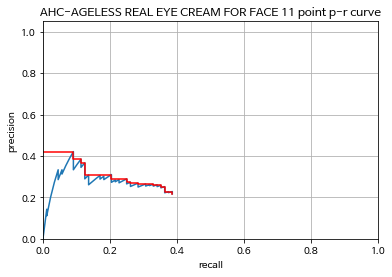

[class]: AHC-Aura Secret Toneup Cream , [AP]: 0.4774739280263859
[Precisions] [1.         1.         0.96774194 0.73913043 0.69230769 0.48717949
 0.36585366 0.         0.         0.         0.        ]


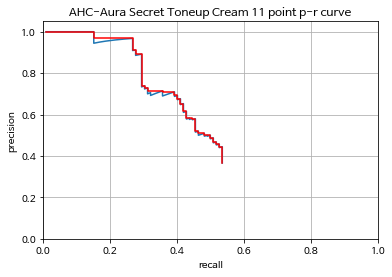

[class]: AHC-ONLY FOR MAN LOTION , [AP]: 0.7259805554503825
[Precisions] [1.         1.         1.         1.         0.97826087 0.89393939
 0.75862069 0.69642857 0.65853659 0.         0.        ]


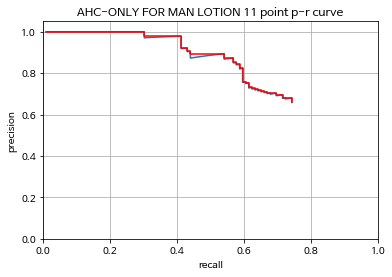

[class]: APIEU-데카소사이드 시카 겔 데이크림 , [AP]: 0.5803903616728404
[Precisions] [1.         1.         1.         0.94285714 0.93617021 0.90322581
 0.60204082 0.         0.         0.         0.        ]


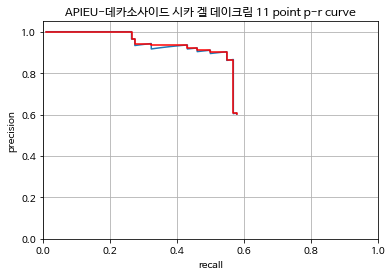

[class]: APIEU-스타트업 포어 프라이머 , [AP]: 0.16656474327360404
[Precisions] [1.         0.36       0.25316456 0.21904762 0.         0.
 0.         0.         0.         0.         0.        ]


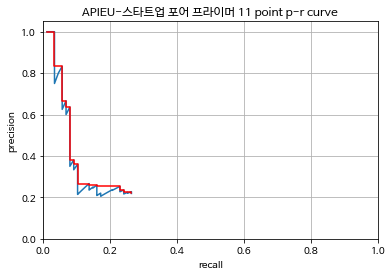

[class]: BANILACO-프라임 프라이머 클래식 , [AP]: 0.4046120782290995
[Precisions] [1.         1.         0.92       0.80851064 0.72222222 0.
 0.         0.         0.         0.         0.        ]


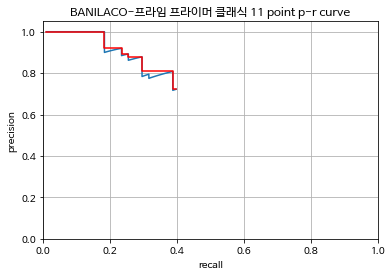

[class]: BELIF-The true cream AQUA BOMB , [AP]: 0.6018595041322313
[Precisions] [1.         1.         1.         1.         0.975      0.87272727
 0.77272727 0.         0.         0.         0.        ]


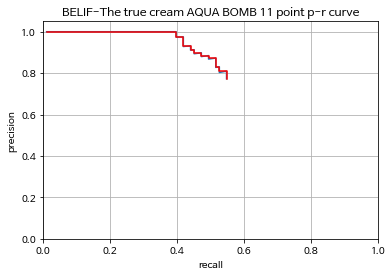

[class]: CLIO-스파클링 라인 프리즘 에어 아이섀도우 , [AP]: 0.3829724705674073
[Precisions] [1.         1.         0.92307692 0.72       0.56962025 0.
 0.         0.         0.         0.         0.        ]


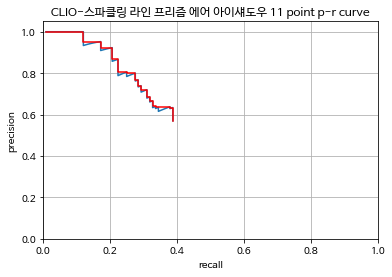

[class]: FERRAGAMO-INCANTO CHARMS , [AP]: 0.670503245666736
[Precisions] [1.         1.         1.         1.         0.95121951 0.88461538
 0.81818182 0.72151899 0.         0.         0.        ]


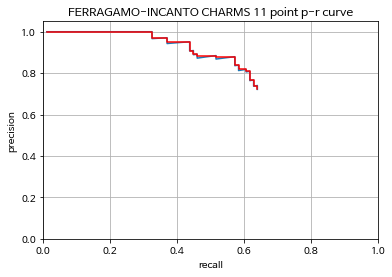

[class]: FERRARI-SCUDERIA BLACK EAU DE TOILETTE SPRAY , [AP]: 0.42829514196731
[Precisions] [1.         1.         0.76666667 0.6744186  0.64516129 0.625
 0.         0.         0.         0.         0.        ]


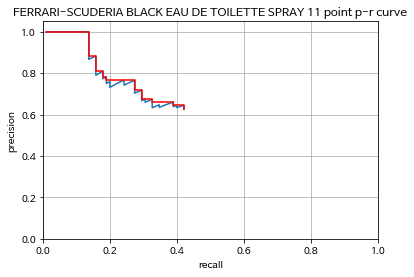

0.4636490811177695
AHC-AGELESS REAL EYE CREAM FOR FACE - 0.1978
AHC-Aura Secret Toneup Cream - 0.4774
AHC-ONLY FOR MAN LOTION - 0.7259
APIEU-데카소사이드 시카 겔 데이크림 - 0.5803
APIEU-스타트업 포어 프라이머 - 0.1665
BANILACO-프라임 프라이머 클래식 - 0.4046
BELIF-The true cream AQUA BOMB - 0.6018
CLIO-스파클링 라인 프리즘 에어 아이섀도우 - 0.3829
FERRAGAMO-INCANTO CHARMS - 0.6705
FERRARI-SCUDERIA BLACK EAU DE TOILETTE SPRAY - 0.4282


In [16]:
from collections import Counter
# https://github.com/rafaelpadilla/Object-Detection-Metrics

def calc_AP(dataset_classes, label, target_all, dfs):
    target = dataset_classes.index(label)
    n_gt = Counter(target_all)

    _df = dfs[label].sort_values(by='confidience', ascending=False) # sort by conf

    _df['FP'] = [0 if tp==1 else 1 for tp in _df['TP']]
    _df['cum_TP'] = _df['TP'].cumsum()
    _df['cum_FP'] = _df['FP'].cumsum()
    _df['precision'] = [tp/(tp+fp) for tp,fp in zip(_df['cum_TP'],_df['cum_FP'])]
    _df['recall'] = _df['cum_TP']/n_gt[target]
    _df['precision_interpolated'] = [_df['precision'][i:].max() for i in range(len(_df['recall']))] 
    _df.reset_index(inplace=True)

    precisions = [_df['precision_interpolated'][_df['recall'].between(0.1*(i-1),0.1*i,inclusive=True)].min() for i in range(11)]
    precisions[0] = 1
    precisions = np.array([0 if p is np.nan else p for p in precisions])
    AP = precisions.mean()
    print('[class]:', label, ', [AP]:', AP)
    print('[Precisions]', precisions)

    plt.plot(_df['recall'], _df['precision'])
    plt.plot(_df['recall'], _df['precision_interpolated'], color='r')
    plt.grid()
    plt.xlim([0,1]), plt.ylim([0,1.05]), plt.title(label+' 11 point p-r curve')
    plt.xlabel('recall'), plt.ylabel('precision')
    plt.show()

    # display(_df)
    return AP, _df
    
# AP_list = np.array([calc_AP(t)[0] for t in voc_classes])

AP_list = []
df_res_list = {}
for cls in voc_classes:
    AP, df_res = calc_AP(voc_classes, cls, target_all_mAP, dfs)
    AP_list.append(AP)
    df_res_list[cls] = df_res
AP_list = np.array(AP_list)

mAP = AP_list.mean()
print(mAP)
for c,ap in zip(voc_classes, AP_list):
    print(c, '-', str(ap)[:6])